In [ ]:
import pandas as pd
import numpy as np
import math
import torch


In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount = True)

Mounted at /content/drive


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/Answer Grading/Hindi.xlsx")
data

In [ ]:
dfs = []
Topics = ["Heat" , "SOUND"]
for i in Topics:
  k = data.loc[data["Topic"] == i]
  dfs.append(k)


In [ ]:
UserAnswers = []
ProcessedAnswers =[]
Grades = []
Questions =[]

for i in range(0,2):
  UserAnswers.append(list(dfs[i]["User Answer"]))
  ProcessedAnswers.append(list(dfs[i]["Processed Answer"]))
  Questions.append(list(dfs[i]["Question"]))
  Grades.append(list(dfs[i]["Grade1"]))


In [ ]:
Text = []
for i in range(0,2):
  t =[]
  for j in range(len(UserAnswers[i])):
    string =  '<CLS> ' + Questions[i][j] + ' <SEP> ' + str(ProcessedAnswers[i][j])
    t.append(string)

  Text.append(t)

total = 0
iter = 0 
for i in range(0,2):
  for j in range(len(UserAnswers[i])):
    k = len(Text[i][j].split())
    total+=k
    iter+=1

# computing average length
average_len = math.ceil(total/iter)
average_len



15

In [ ]:
for i in range(0,2):
  for j in range(len(UserAnswers[i])):
    k = len(Text[i][j].split())
    if k > average_len:
      temp = Text[i][j].split()[0:average_len]
      Text[i][j] = " ".join(temp)
    elif k < average_len:
      while(k < average_len):
        Text[i][j] += ' <PAD> '
        k+=1

# Every input sequence is of same length (with this preprocessing done)


In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing fast text hindi embeddings

import fasttext
import fasttext.util
ft = fasttext.load_model('/content/drive/MyDrive/Answer Grading/wiki.hi.bin')


In [ ]:
word = "नृत्य"
print("Embedding Shape is {}".format(ft.get_word_vector(word).shape))
print("Nearest Neighbors to {} are:".format(word))
ft.get_nearest_neighbors(word)
ft.get_word_vector(word)

For every word got word embeds

Problem is how to store them?

Problem 1 => All sequences should be of same size


Problem 2 => Creating test and train Loaders

In [ ]:
wordEmbeds = [[],[]]

for i in range(0,2):
  for j in range(len(Text[i])):
    text_vector=[]
    for k in Text[i][j].split():
      text_vector.append(list(ft.get_word_vector(k)))
    
    wordEmbeds[i].append(text_vector)
  wordEmbeds[i] = np.array(wordEmbeds[i])
  print(wordEmbeds[i].shape)
  np.save('Embeds' + str(i) , wordEmbeds[i])



(1427, 15, 300)
(2005, 15, 300)


In [ ]:
from sklearn.model_selection import train_test_split

train_loaders = []
test_loaders = []
for i in range(0,2):
  X_train,X_test,Y_train,Y_test = train_test_split(wordEmbeds[i], np.array(Grades[i]) , test_size=0.2, random_state=33)

  X_train = torch.Tensor(X_train)
  X_test = torch.Tensor(X_test)
  Y_train = torch.LongTensor(Y_train)
  Y_test = torch.LongTensor(Y_test)

  train_loaders.append(torch.utils.data.DataLoader(X_train, batch_size=16, shuffle=True))
  test_loaders.append(torch.utils.data.DataLoader(X_test, batch_size=16, shuffle=True))


In [ ]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt 


# changing device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPS = torch.finfo(torch.float).eps # numerical logs

class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
        super(VRNN, self).__init__()

        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers

        #feature-extracting transformations
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU())

        #encoder
        self.enc = nn.Sequential(
            nn.Linear(h_dim + h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.enc_mean = nn.Linear(h_dim, z_dim)
        self.enc_std = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.Softplus())

        #prior
        self.prior = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.prior_mean = nn.Linear(h_dim, z_dim)
        self.prior_std = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.Softplus())

        #decoder
        self.dec = nn.Sequential(
            nn.Linear(h_dim + h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.dec_std = nn.Sequential(
            nn.Linear(h_dim, x_dim),
            nn.Softplus())
        #self.dec_mean = nn.Linear(h_dim, x_dim)
        self.dec_mean = nn.Sequential(
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid())

        #recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)


    def forward(self, x):

        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0

        h = torch.zeros(self.n_layers, x.size(1), self.h_dim, device=device)
        for t in range(x.size(0)):
            phi_x_t = self.phi_x(x[t])
            #encoder
            enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
            enc_mean_t = self.enc_mean(enc_t)
            enc_std_t = self.enc_std(enc_t) 
            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)

            #sampling and reparameterization
            z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
            phi_z_t = self.phi_z(z_t)

            #decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            dec_std_t = self.dec_std(dec_t)

            #recurrence
            out, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            #computing losses
            kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
            #nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
            nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

            all_enc_std.append(enc_std_t)
            all_enc_mean.append(enc_mean_t)
            all_dec_mean.append(dec_mean_t)
            all_dec_std.append(dec_std_t)

        return kld_loss, nll_loss, h ,\
            (all_enc_mean, all_enc_std), \
            (all_dec_mean, all_dec_std)


    def sample(self, seq_len):

        sample = torch.zeros(seq_len, self.x_dim, device=device)

        h = torch.zeros(self.n_layers, 1, self.h_dim, device=device)
        for t in range(seq_len):

            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)

            #sampling and reparameterization
            z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
            phi_z_t = self.phi_z(z_t)

            #decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            #dec_std_t = self.dec_std(dec_t)

            phi_x_t = self.phi_x(dec_mean_t)

            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            sample[t] = dec_mean_t.data

        return sample


    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)


    def _init_weights(self, stdv):
        pass


    def _reparameterized_sample(self, mean, std):
        """using std to sample"""
        eps = torch.empty(size=std.size(), device=device, dtype=torch.float).normal_()
        return eps.mul(std).add_(mean)


    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        """Using std to compute KLD"""

        kld_element =  (2 * torch.log(std_2 + EPS) - 2 * torch.log(std_1 + EPS) + 
            (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
            std_2.pow(2) - 1)
        return	0.5 * torch.sum(kld_element)


    def _nll_bernoulli(self, theta, x):
        return - (torch.sum(x*torch.log(theta + EPS) + (1-x)*torch.log(1-theta-EPS)))


    def _nll_gauss(self, mean, std, x):
        return - (torch.sum(torch.log(std + EPS) + math.log(2*torch.pi)/2 + (x - mean).pow(2)/(2*std.pow(2))))

Train Epoch: 1 [0/1136 (0%)]	 KLD Loss: 5.945648 	 NLL Loss: 3123.355957


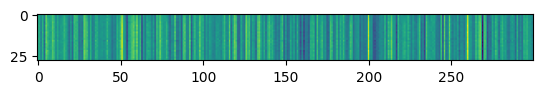

Train Epoch: 1 [160/1136 (14%)]	 KLD Loss: 0.154683 	 NLL Loss: 3112.231201


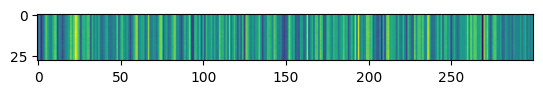

Train Epoch: 1 [320/1136 (28%)]	 KLD Loss: 0.037200 	 NLL Loss: 3111.655029


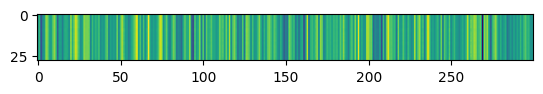

Train Epoch: 1 [480/1136 (42%)]	 KLD Loss: 0.011122 	 NLL Loss: 3109.128174


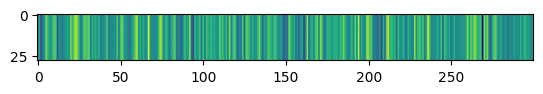

Train Epoch: 1 [640/1136 (56%)]	 KLD Loss: 0.005870 	 NLL Loss: 3110.808594


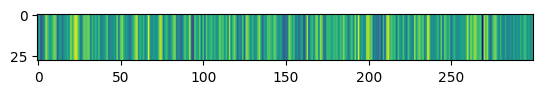

Train Epoch: 1 [800/1136 (69%)]	 KLD Loss: 0.002669 	 NLL Loss: 3111.900391


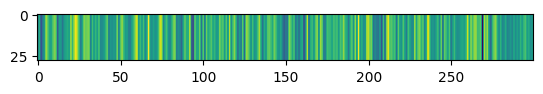

Train Epoch: 1 [960/1136 (83%)]	 KLD Loss: 0.001581 	 NLL Loss: 3110.499023


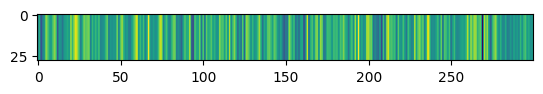

Train Epoch: 1 [1120/1136 (97%)]	 KLD Loss: 0.000887 	 NLL Loss: 3112.378174


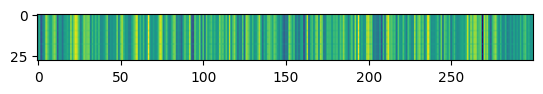

====> Epoch: 1 Average loss: 3111.6401
Train Epoch: 2 [0/1136 (0%)]	 KLD Loss: 0.000903 	 NLL Loss: 3110.911133


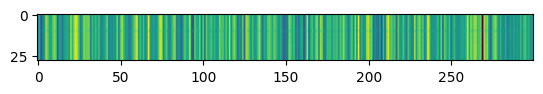

Train Epoch: 2 [160/1136 (14%)]	 KLD Loss: 0.002225 	 NLL Loss: 3115.773193


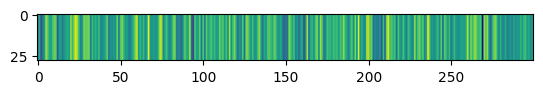

Train Epoch: 2 [320/1136 (28%)]	 KLD Loss: 0.000666 	 NLL Loss: 3110.125977


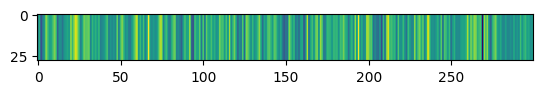

Train Epoch: 2 [480/1136 (42%)]	 KLD Loss: 0.000769 	 NLL Loss: 3110.268311


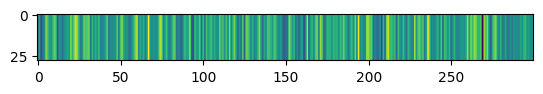

Train Epoch: 2 [640/1136 (56%)]	 KLD Loss: 0.000442 	 NLL Loss: 3110.545166


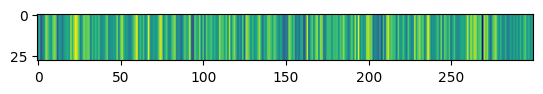

Train Epoch: 2 [800/1136 (69%)]	 KLD Loss: 0.000447 	 NLL Loss: 3109.699951


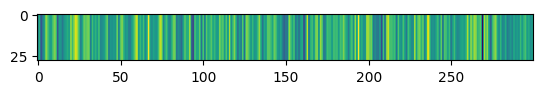

Train Epoch: 2 [960/1136 (83%)]	 KLD Loss: 0.000361 	 NLL Loss: 3117.037598


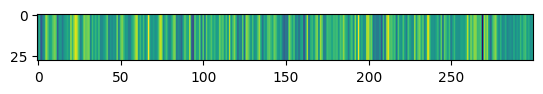

Train Epoch: 2 [1120/1136 (97%)]	 KLD Loss: 0.000241 	 NLL Loss: 3101.860596


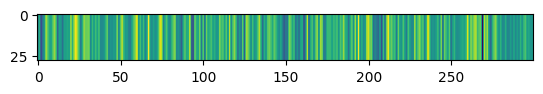

====> Epoch: 2 Average loss: 3109.7371
Train Epoch: 3 [0/1136 (0%)]	 KLD Loss: 0.000303 	 NLL Loss: 3120.730469


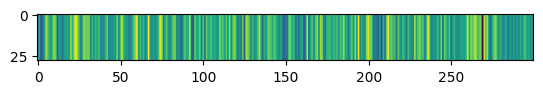

Train Epoch: 3 [160/1136 (14%)]	 KLD Loss: 0.000115 	 NLL Loss: 3108.291016


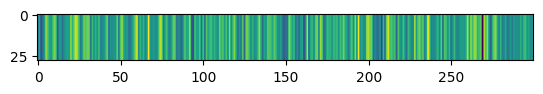

Train Epoch: 3 [320/1136 (28%)]	 KLD Loss: 0.000066 	 NLL Loss: 3111.716064


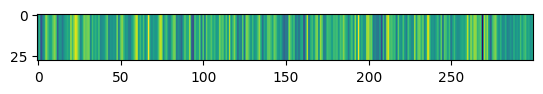

Train Epoch: 3 [480/1136 (42%)]	 KLD Loss: 0.000137 	 NLL Loss: 3103.587891


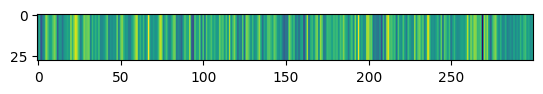

Train Epoch: 3 [640/1136 (56%)]	 KLD Loss: 0.000090 	 NLL Loss: 3117.992432


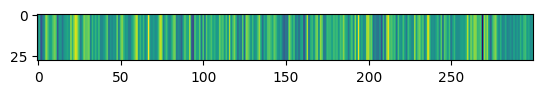

Train Epoch: 3 [800/1136 (69%)]	 KLD Loss: 0.000120 	 NLL Loss: 3109.042969


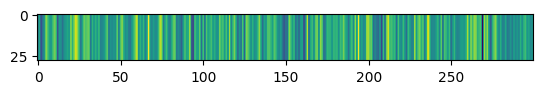

Train Epoch: 3 [960/1136 (83%)]	 KLD Loss: 0.000131 	 NLL Loss: 3107.648682


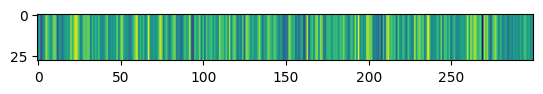

Train Epoch: 3 [1120/1136 (97%)]	 KLD Loss: 0.000754 	 NLL Loss: 3111.599609


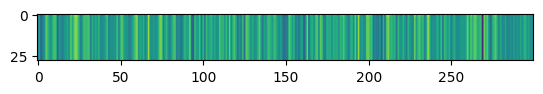

====> Epoch: 3 Average loss: 3109.7457
Train Epoch: 4 [0/1136 (0%)]	 KLD Loss: 0.001134 	 NLL Loss: 3108.954834


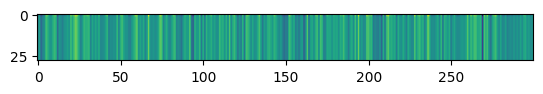

Train Epoch: 4 [160/1136 (14%)]	 KLD Loss: 0.000282 	 NLL Loss: 3098.643799


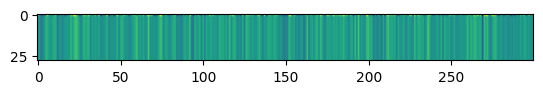

Train Epoch: 4 [320/1136 (28%)]	 KLD Loss: 0.000946 	 NLL Loss: 3108.227783


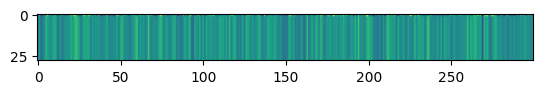

Train Epoch: 4 [480/1136 (42%)]	 KLD Loss: 0.001402 	 NLL Loss: 3107.525635


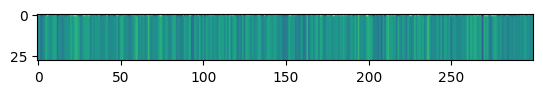

Train Epoch: 4 [640/1136 (56%)]	 KLD Loss: 0.002093 	 NLL Loss: 3100.698242


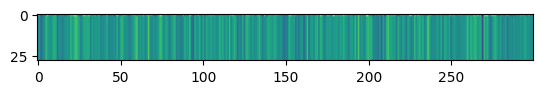

Train Epoch: 4 [800/1136 (69%)]	 KLD Loss: 0.002979 	 NLL Loss: 3114.023926


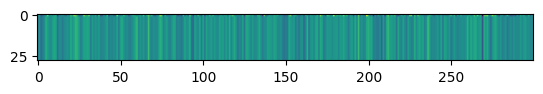

Train Epoch: 4 [960/1136 (83%)]	 KLD Loss: 0.000961 	 NLL Loss: 3106.502686


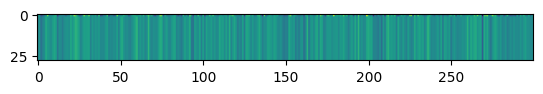

Train Epoch: 4 [1120/1136 (97%)]	 KLD Loss: 0.000785 	 NLL Loss: 3108.937988


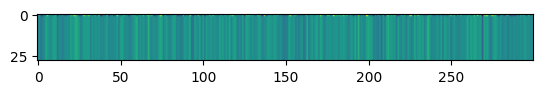

====> Epoch: 4 Average loss: 3107.5002
Train Epoch: 5 [0/1136 (0%)]	 KLD Loss: 0.002352 	 NLL Loss: 3109.702881


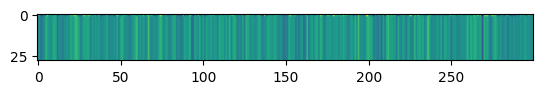

Train Epoch: 5 [160/1136 (14%)]	 KLD Loss: 0.000421 	 NLL Loss: 3117.899658


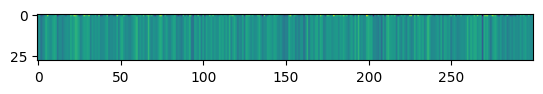

Train Epoch: 5 [320/1136 (28%)]	 KLD Loss: 0.000688 	 NLL Loss: 3111.644043


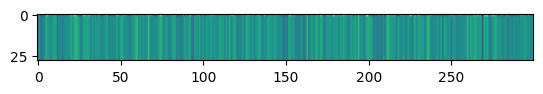

Train Epoch: 5 [480/1136 (42%)]	 KLD Loss: 0.000360 	 NLL Loss: 3107.312988


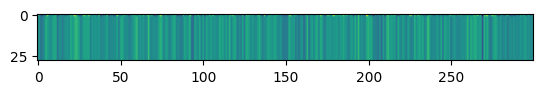

Train Epoch: 5 [640/1136 (56%)]	 KLD Loss: 0.000354 	 NLL Loss: 3105.241699


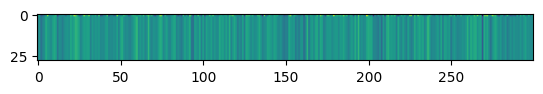

Train Epoch: 5 [800/1136 (69%)]	 KLD Loss: 0.000528 	 NLL Loss: 3105.923584


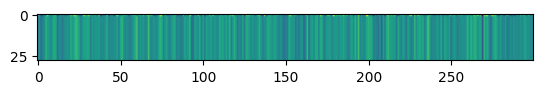

Train Epoch: 5 [960/1136 (83%)]	 KLD Loss: 0.000387 	 NLL Loss: 3105.963135


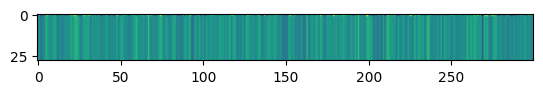

Train Epoch: 5 [1120/1136 (97%)]	 KLD Loss: 0.000236 	 NLL Loss: 3106.867676


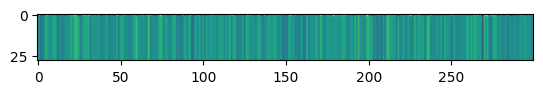

====> Epoch: 5 Average loss: 3107.6466
Train Epoch: 6 [0/1136 (0%)]	 KLD Loss: 0.000485 	 NLL Loss: 3105.705566


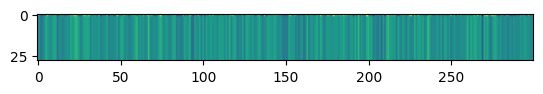

Train Epoch: 6 [160/1136 (14%)]	 KLD Loss: 0.000492 	 NLL Loss: 3109.347168


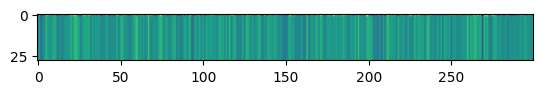

Train Epoch: 6 [320/1136 (28%)]	 KLD Loss: 0.000616 	 NLL Loss: 3107.720947


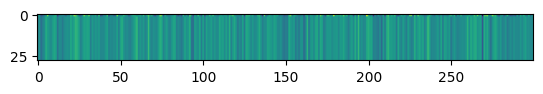

Train Epoch: 6 [480/1136 (42%)]	 KLD Loss: 0.000649 	 NLL Loss: 3116.693359


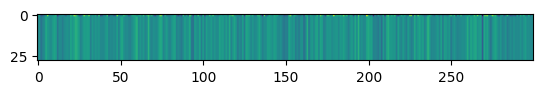

Train Epoch: 6 [640/1136 (56%)]	 KLD Loss: 0.000438 	 NLL Loss: 3107.270996


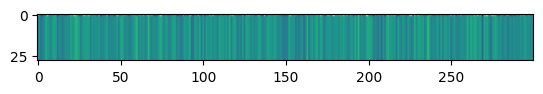

Train Epoch: 6 [800/1136 (69%)]	 KLD Loss: 0.000334 	 NLL Loss: 3107.258545


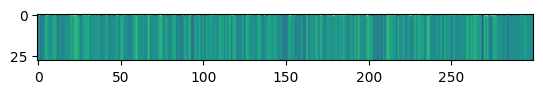

Train Epoch: 6 [960/1136 (83%)]	 KLD Loss: 0.000308 	 NLL Loss: 3110.778076


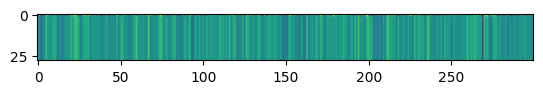

Train Epoch: 6 [1120/1136 (97%)]	 KLD Loss: 0.000325 	 NLL Loss: 3106.911621


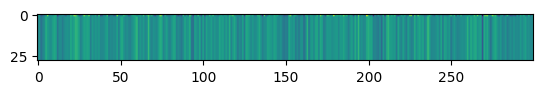

====> Epoch: 6 Average loss: 3107.8057
Train Epoch: 7 [0/1136 (0%)]	 KLD Loss: 0.000324 	 NLL Loss: 3107.481934


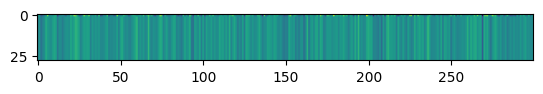

Train Epoch: 7 [160/1136 (14%)]	 KLD Loss: 0.000120 	 NLL Loss: 3101.550293


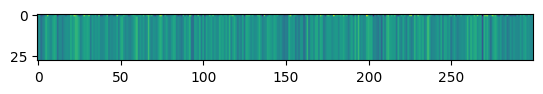

Train Epoch: 7 [320/1136 (28%)]	 KLD Loss: 0.000077 	 NLL Loss: 3109.238281


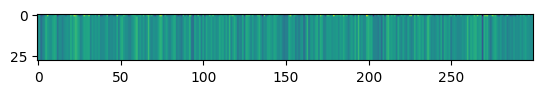

Train Epoch: 7 [480/1136 (42%)]	 KLD Loss: 0.000100 	 NLL Loss: 3108.847412


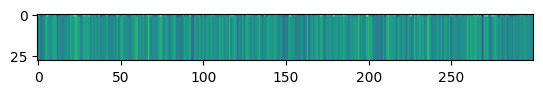

Train Epoch: 7 [640/1136 (56%)]	 KLD Loss: 0.000106 	 NLL Loss: 3106.059570


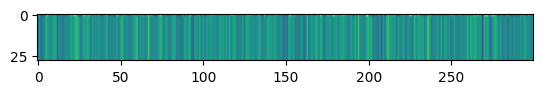

Train Epoch: 7 [800/1136 (69%)]	 KLD Loss: 0.000115 	 NLL Loss: 3107.091064


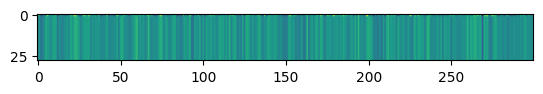

Train Epoch: 7 [960/1136 (83%)]	 KLD Loss: 0.000175 	 NLL Loss: 3108.781006


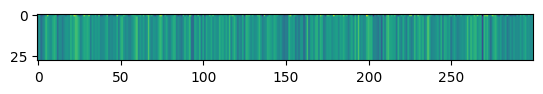

Train Epoch: 7 [1120/1136 (97%)]	 KLD Loss: 0.000227 	 NLL Loss: 3105.757080


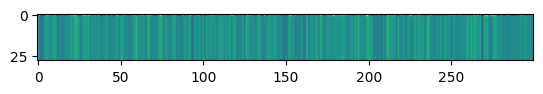

====> Epoch: 7 Average loss: 3107.6245
Train Epoch: 8 [0/1136 (0%)]	 KLD Loss: 0.000487 	 NLL Loss: 3107.445557


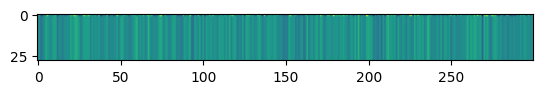

Train Epoch: 8 [160/1136 (14%)]	 KLD Loss: 0.001275 	 NLL Loss: 3107.102051


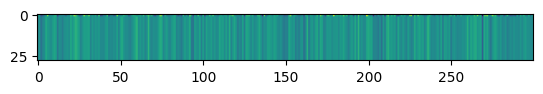

Train Epoch: 8 [320/1136 (28%)]	 KLD Loss: 0.002483 	 NLL Loss: 3107.262939


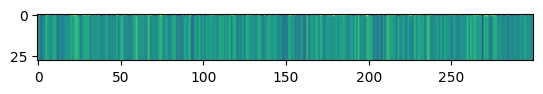

Train Epoch: 8 [480/1136 (42%)]	 KLD Loss: 0.000221 	 NLL Loss: 3109.178223


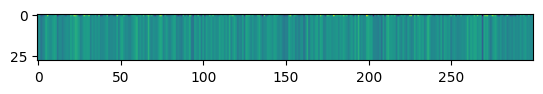

Train Epoch: 8 [640/1136 (56%)]	 KLD Loss: 0.000761 	 NLL Loss: 3106.699951


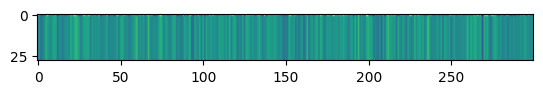

Train Epoch: 8 [800/1136 (69%)]	 KLD Loss: 0.000353 	 NLL Loss: 3104.901611


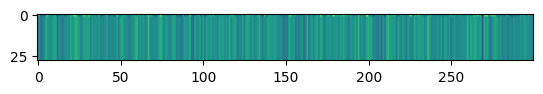

Train Epoch: 8 [960/1136 (83%)]	 KLD Loss: 0.000104 	 NLL Loss: 3104.730713


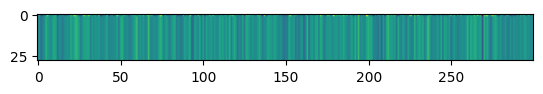

Train Epoch: 8 [1120/1136 (97%)]	 KLD Loss: 0.000101 	 NLL Loss: 3107.130859


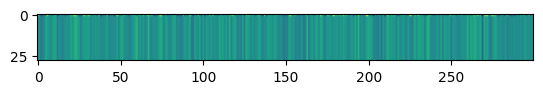

====> Epoch: 8 Average loss: 3107.2596
Train Epoch: 9 [0/1136 (0%)]	 KLD Loss: 0.000161 	 NLL Loss: 3108.608887


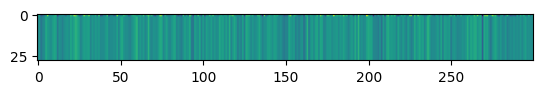

Train Epoch: 9 [160/1136 (14%)]	 KLD Loss: 0.000124 	 NLL Loss: 3099.428223


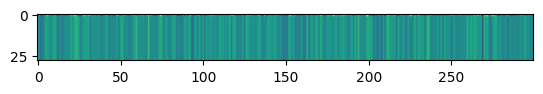

Train Epoch: 9 [320/1136 (28%)]	 KLD Loss: 0.000103 	 NLL Loss: 3107.869141


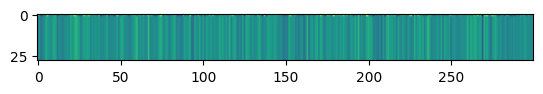

Train Epoch: 9 [480/1136 (42%)]	 KLD Loss: 0.000044 	 NLL Loss: 3100.551270


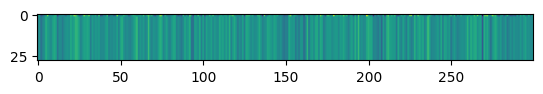

Train Epoch: 9 [640/1136 (56%)]	 KLD Loss: 0.000065 	 NLL Loss: 3109.935059


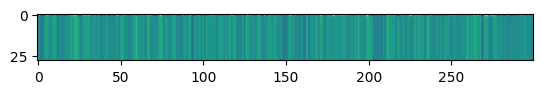

Train Epoch: 9 [800/1136 (69%)]	 KLD Loss: 0.000134 	 NLL Loss: 3107.983398


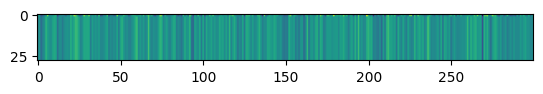

Train Epoch: 9 [960/1136 (83%)]	 KLD Loss: 0.000209 	 NLL Loss: 3107.682617


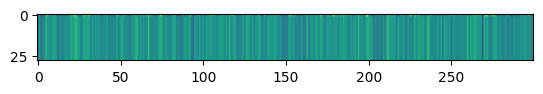

Train Epoch: 9 [1120/1136 (97%)]	 KLD Loss: 0.000410 	 NLL Loss: 3106.939941


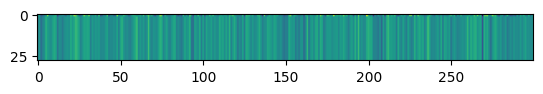

====> Epoch: 9 Average loss: 3107.4098
Train Epoch: 10 [0/1136 (0%)]	 KLD Loss: 0.000968 	 NLL Loss: 3107.988281


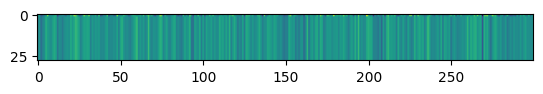

Train Epoch: 10 [160/1136 (14%)]	 KLD Loss: 0.000285 	 NLL Loss: 3107.050049


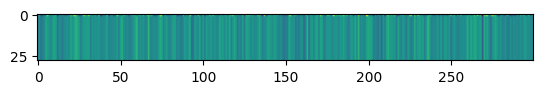

Train Epoch: 10 [320/1136 (28%)]	 KLD Loss: 0.000327 	 NLL Loss: 3106.913574


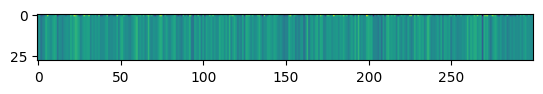

Train Epoch: 10 [480/1136 (42%)]	 KLD Loss: 0.000686 	 NLL Loss: 3107.745361


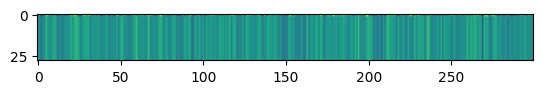

Train Epoch: 10 [640/1136 (56%)]	 KLD Loss: 0.000352 	 NLL Loss: 3107.128906


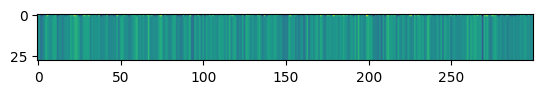

Train Epoch: 10 [800/1136 (69%)]	 KLD Loss: 0.000375 	 NLL Loss: 3108.535889


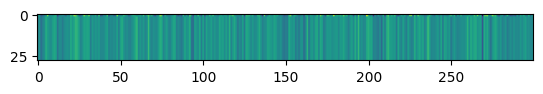

Train Epoch: 10 [960/1136 (83%)]	 KLD Loss: 0.000097 	 NLL Loss: 3106.777100


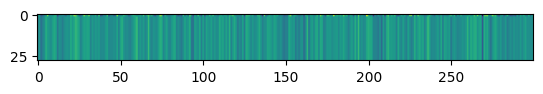

Train Epoch: 10 [1120/1136 (97%)]	 KLD Loss: 0.000236 	 NLL Loss: 3107.644287


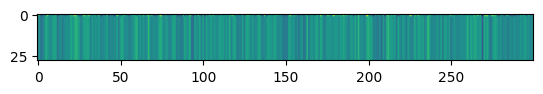

====> Epoch: 10 Average loss: 3107.0245
Train Epoch: 11 [0/1136 (0%)]	 KLD Loss: 0.000152 	 NLL Loss: 3111.552002


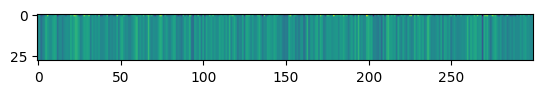

Train Epoch: 11 [160/1136 (14%)]	 KLD Loss: 0.000414 	 NLL Loss: 3107.295166


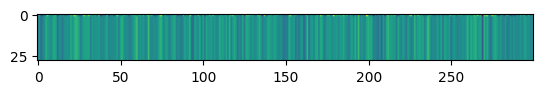

Train Epoch: 11 [320/1136 (28%)]	 KLD Loss: 0.000274 	 NLL Loss: 3105.930664


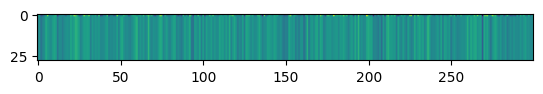

Train Epoch: 11 [480/1136 (42%)]	 KLD Loss: 0.000645 	 NLL Loss: 3108.031494


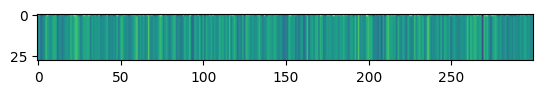

Train Epoch: 11 [640/1136 (56%)]	 KLD Loss: 0.000344 	 NLL Loss: 3106.305420


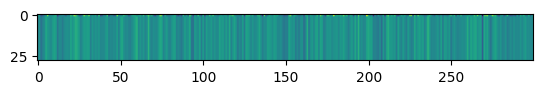

Train Epoch: 11 [800/1136 (69%)]	 KLD Loss: 0.000326 	 NLL Loss: 3106.896240


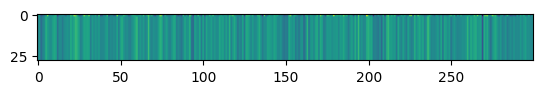

Train Epoch: 11 [960/1136 (83%)]	 KLD Loss: 0.000047 	 NLL Loss: 3109.761475


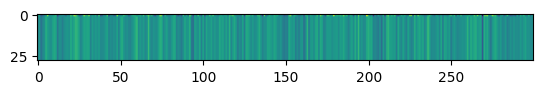

Train Epoch: 11 [1120/1136 (97%)]	 KLD Loss: 0.000078 	 NLL Loss: 3108.017578


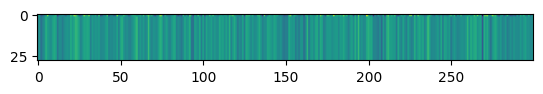

====> Epoch: 11 Average loss: 3107.4237
Train Epoch: 12 [0/1136 (0%)]	 KLD Loss: 0.000112 	 NLL Loss: 3109.531250


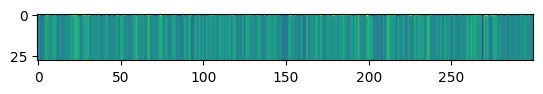

Train Epoch: 12 [160/1136 (14%)]	 KLD Loss: 0.000050 	 NLL Loss: 3107.161377


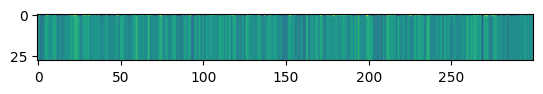

Train Epoch: 12 [320/1136 (28%)]	 KLD Loss: 0.000014 	 NLL Loss: 3115.174805


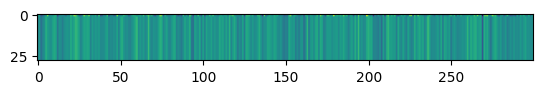

Train Epoch: 12 [480/1136 (42%)]	 KLD Loss: 0.000016 	 NLL Loss: 3122.018066


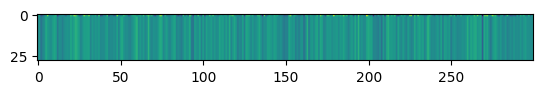

Train Epoch: 12 [640/1136 (56%)]	 KLD Loss: 0.000011 	 NLL Loss: 3104.995850


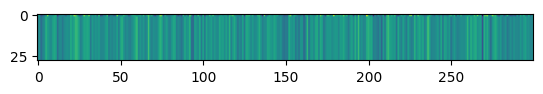

Train Epoch: 12 [800/1136 (69%)]	 KLD Loss: 0.000013 	 NLL Loss: 3106.225342


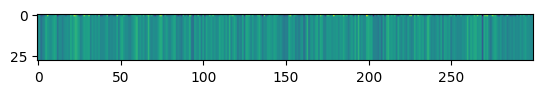

Train Epoch: 12 [960/1136 (83%)]	 KLD Loss: 0.000027 	 NLL Loss: 3105.588623


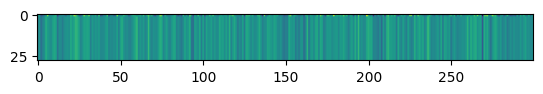

Train Epoch: 12 [1120/1136 (97%)]	 KLD Loss: 0.000046 	 NLL Loss: 3109.303955


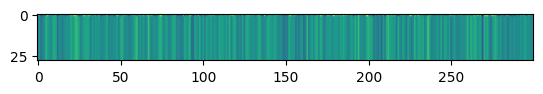

====> Epoch: 12 Average loss: 3107.0441
Train Epoch: 13 [0/1136 (0%)]	 KLD Loss: 0.000152 	 NLL Loss: 3102.390869


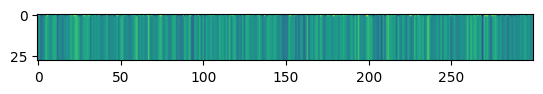

Train Epoch: 13 [160/1136 (14%)]	 KLD Loss: 0.000164 	 NLL Loss: 3108.253662


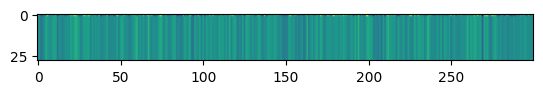

Train Epoch: 13 [320/1136 (28%)]	 KLD Loss: 0.000067 	 NLL Loss: 3106.693359


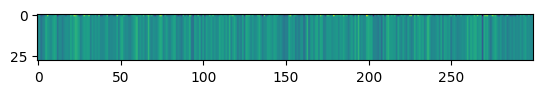

Train Epoch: 13 [480/1136 (42%)]	 KLD Loss: 0.000066 	 NLL Loss: 3115.807129


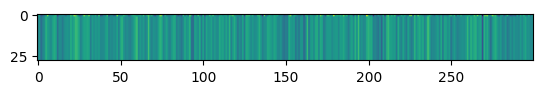

Train Epoch: 13 [640/1136 (56%)]	 KLD Loss: 0.000040 	 NLL Loss: 3099.731445


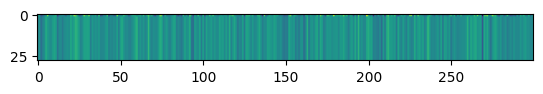

Train Epoch: 13 [800/1136 (69%)]	 KLD Loss: 0.000055 	 NLL Loss: 3101.661621


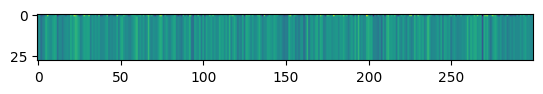

Train Epoch: 13 [960/1136 (83%)]	 KLD Loss: 0.000043 	 NLL Loss: 3107.709961


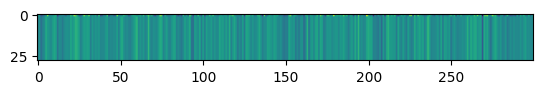

Train Epoch: 13 [1120/1136 (97%)]	 KLD Loss: 0.000083 	 NLL Loss: 3106.242432


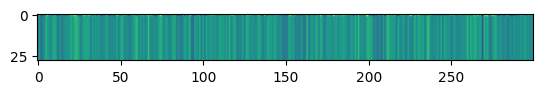

====> Epoch: 13 Average loss: 3107.1545
Train Epoch: 14 [0/1136 (0%)]	 KLD Loss: 0.000114 	 NLL Loss: 3107.855225


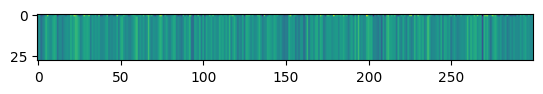

Train Epoch: 14 [160/1136 (14%)]	 KLD Loss: 0.000146 	 NLL Loss: 3106.930176


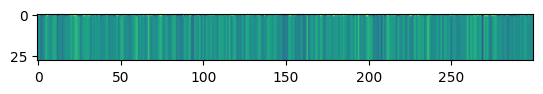

Train Epoch: 14 [320/1136 (28%)]	 KLD Loss: 0.000108 	 NLL Loss: 3107.692627


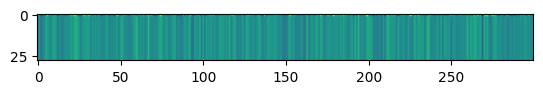

Train Epoch: 14 [480/1136 (42%)]	 KLD Loss: 0.000109 	 NLL Loss: 3111.243652


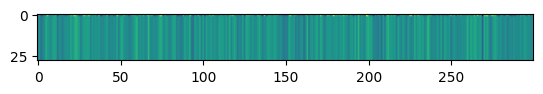

Train Epoch: 14 [640/1136 (56%)]	 KLD Loss: 0.000105 	 NLL Loss: 3111.863281


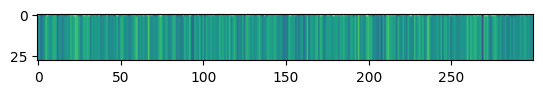

Train Epoch: 14 [800/1136 (69%)]	 KLD Loss: 0.000130 	 NLL Loss: 3113.263672


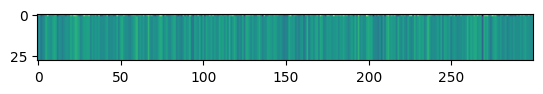

Train Epoch: 14 [960/1136 (83%)]	 KLD Loss: 0.000075 	 NLL Loss: 3109.319336


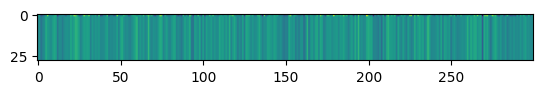

Train Epoch: 14 [1120/1136 (97%)]	 KLD Loss: 0.000041 	 NLL Loss: 3105.775146


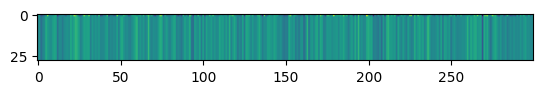

====> Epoch: 14 Average loss: 3107.1724
Train Epoch: 15 [0/1136 (0%)]	 KLD Loss: 0.000099 	 NLL Loss: 3103.067139


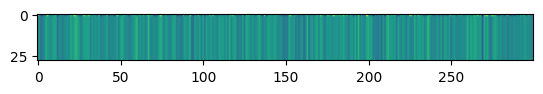

Train Epoch: 15 [160/1136 (14%)]	 KLD Loss: 0.000062 	 NLL Loss: 3106.035645


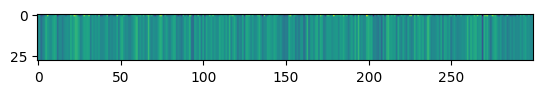

Train Epoch: 15 [320/1136 (28%)]	 KLD Loss: 0.000117 	 NLL Loss: 3098.442871


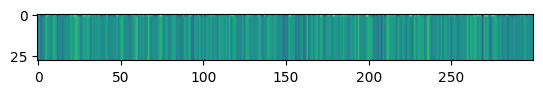

Train Epoch: 15 [480/1136 (42%)]	 KLD Loss: 0.000278 	 NLL Loss: 3107.102295


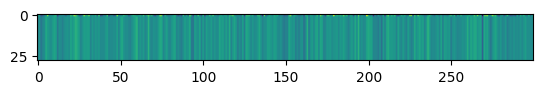

Train Epoch: 15 [640/1136 (56%)]	 KLD Loss: 0.000307 	 NLL Loss: 3110.916992


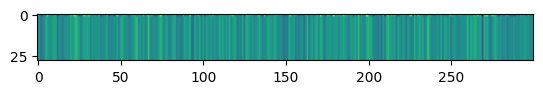

Train Epoch: 15 [800/1136 (69%)]	 KLD Loss: 0.000236 	 NLL Loss: 3108.268799


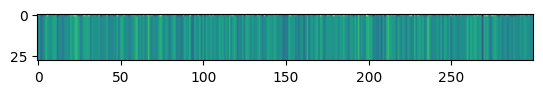

Train Epoch: 15 [960/1136 (83%)]	 KLD Loss: 0.000170 	 NLL Loss: 3106.828125


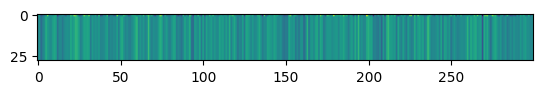

Train Epoch: 15 [1120/1136 (97%)]	 KLD Loss: 0.000144 	 NLL Loss: 3106.024414


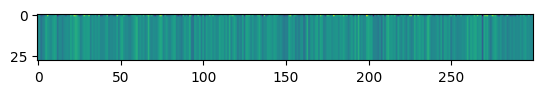

====> Epoch: 15 Average loss: 3106.2176
Train Epoch: 16 [0/1136 (0%)]	 KLD Loss: 0.000271 	 NLL Loss: 3106.742188


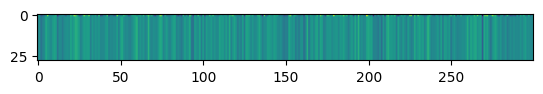

Train Epoch: 16 [160/1136 (14%)]	 KLD Loss: 0.000268 	 NLL Loss: 3099.658203


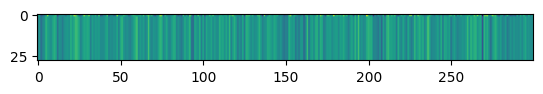

Train Epoch: 16 [320/1136 (28%)]	 KLD Loss: 0.000189 	 NLL Loss: 3098.220215


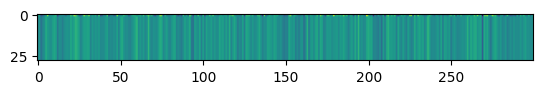

Train Epoch: 16 [480/1136 (42%)]	 KLD Loss: 0.000264 	 NLL Loss: 3109.959717


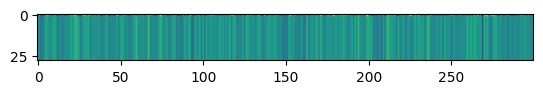

Train Epoch: 16 [640/1136 (56%)]	 KLD Loss: 0.000338 	 NLL Loss: 3106.290527


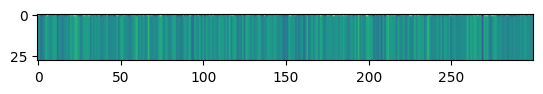

Train Epoch: 16 [800/1136 (69%)]	 KLD Loss: 0.000288 	 NLL Loss: 3102.619629


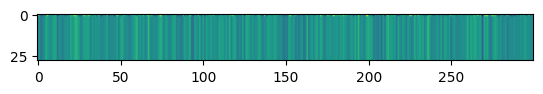

Train Epoch: 16 [960/1136 (83%)]	 KLD Loss: 0.000510 	 NLL Loss: 3105.986084


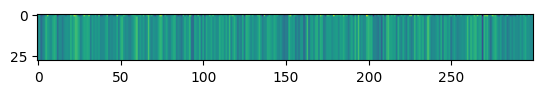

Train Epoch: 16 [1120/1136 (97%)]	 KLD Loss: 0.000072 	 NLL Loss: 3107.587402


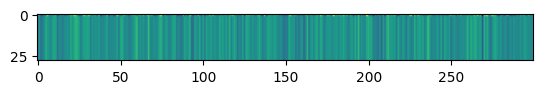

====> Epoch: 16 Average loss: 3107.1204
Train Epoch: 17 [0/1136 (0%)]	 KLD Loss: 0.000317 	 NLL Loss: 3107.012451


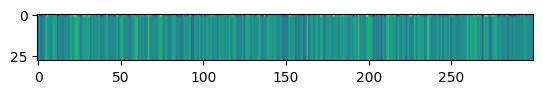

Train Epoch: 17 [160/1136 (14%)]	 KLD Loss: 0.000099 	 NLL Loss: 3107.152832


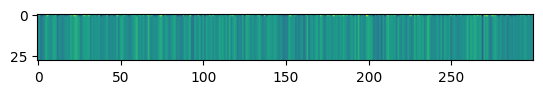

Train Epoch: 17 [320/1136 (28%)]	 KLD Loss: 0.000075 	 NLL Loss: 3108.611572


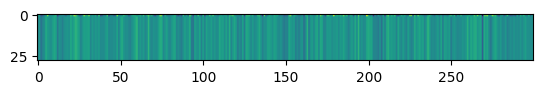

Train Epoch: 17 [480/1136 (42%)]	 KLD Loss: 0.000075 	 NLL Loss: 3110.458252


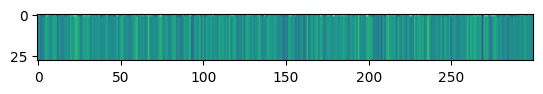

Train Epoch: 17 [640/1136 (56%)]	 KLD Loss: 0.000066 	 NLL Loss: 3098.699951


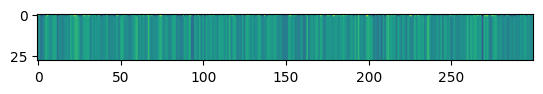

Train Epoch: 17 [800/1136 (69%)]	 KLD Loss: 0.000152 	 NLL Loss: 3100.415527


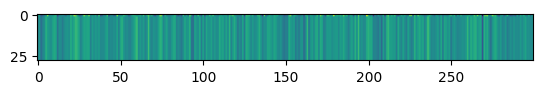

Train Epoch: 17 [960/1136 (83%)]	 KLD Loss: 0.000051 	 NLL Loss: 3108.579346


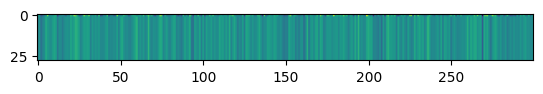

Train Epoch: 17 [1120/1136 (97%)]	 KLD Loss: 0.000054 	 NLL Loss: 3105.720703


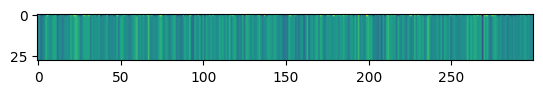

====> Epoch: 17 Average loss: 3106.8524
Train Epoch: 18 [0/1136 (0%)]	 KLD Loss: 0.000111 	 NLL Loss: 3108.457275


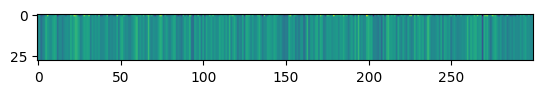

Train Epoch: 18 [160/1136 (14%)]	 KLD Loss: 0.000060 	 NLL Loss: 3105.309570


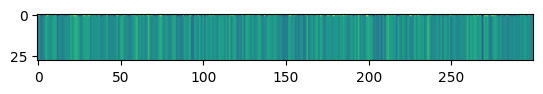

Train Epoch: 18 [320/1136 (28%)]	 KLD Loss: 0.000058 	 NLL Loss: 3105.879639


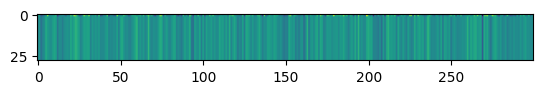

Train Epoch: 18 [480/1136 (42%)]	 KLD Loss: 0.000132 	 NLL Loss: 3113.039795


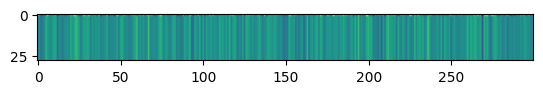

Train Epoch: 18 [640/1136 (56%)]	 KLD Loss: 0.000109 	 NLL Loss: 3107.349121


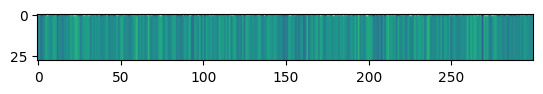

Train Epoch: 18 [800/1136 (69%)]	 KLD Loss: 0.000065 	 NLL Loss: 3106.747070


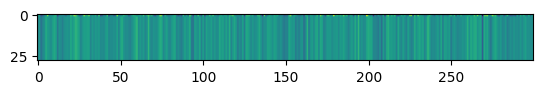

Train Epoch: 18 [960/1136 (83%)]	 KLD Loss: 0.000090 	 NLL Loss: 3110.209961


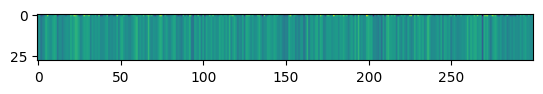

Train Epoch: 18 [1120/1136 (97%)]	 KLD Loss: 0.000045 	 NLL Loss: 3095.305176


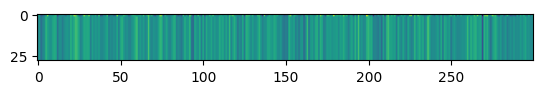

====> Epoch: 18 Average loss: 3107.0870
Train Epoch: 19 [0/1136 (0%)]	 KLD Loss: 0.000259 	 NLL Loss: 3109.611816


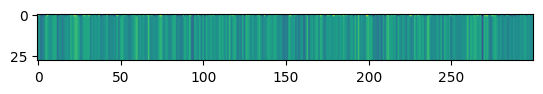

Train Epoch: 19 [160/1136 (14%)]	 KLD Loss: 0.000081 	 NLL Loss: 3107.599609


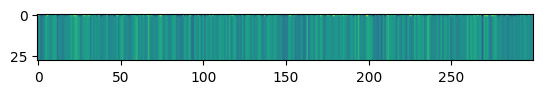

Train Epoch: 19 [320/1136 (28%)]	 KLD Loss: 0.000029 	 NLL Loss: 3108.272949


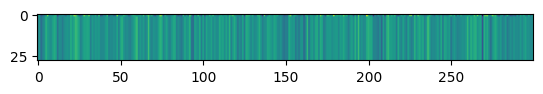

Train Epoch: 19 [480/1136 (42%)]	 KLD Loss: 0.000036 	 NLL Loss: 3107.839844


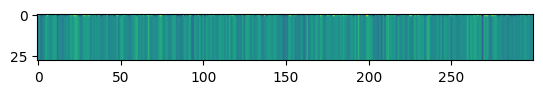

Train Epoch: 19 [640/1136 (56%)]	 KLD Loss: 0.000033 	 NLL Loss: 3104.249512


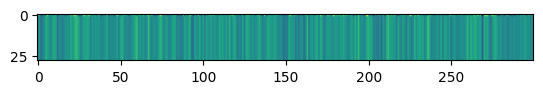

Train Epoch: 19 [800/1136 (69%)]	 KLD Loss: 0.000032 	 NLL Loss: 3103.939697


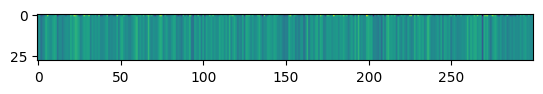

Train Epoch: 19 [960/1136 (83%)]	 KLD Loss: 0.000152 	 NLL Loss: 3110.957275


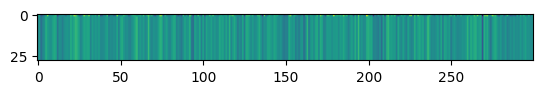

Train Epoch: 19 [1120/1136 (97%)]	 KLD Loss: 0.000244 	 NLL Loss: 3104.944580


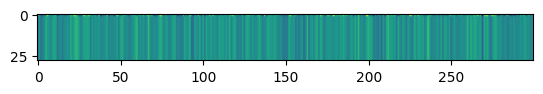

====> Epoch: 19 Average loss: 3107.4726
Train Epoch: 20 [0/1136 (0%)]	 KLD Loss: 0.000399 	 NLL Loss: 3108.409912


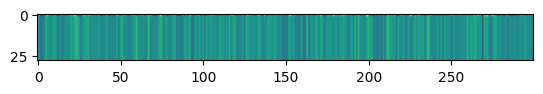

Train Epoch: 20 [160/1136 (14%)]	 KLD Loss: 0.000132 	 NLL Loss: 3107.569580


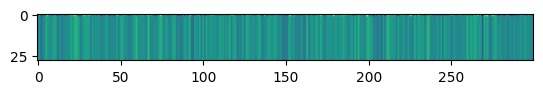

Train Epoch: 20 [320/1136 (28%)]	 KLD Loss: 0.000085 	 NLL Loss: 3108.590820


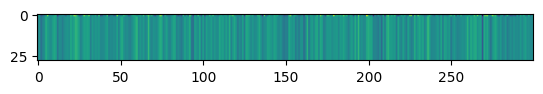

Train Epoch: 20 [480/1136 (42%)]	 KLD Loss: 0.000074 	 NLL Loss: 3100.297363


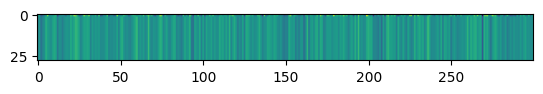

Train Epoch: 20 [640/1136 (56%)]	 KLD Loss: 0.000037 	 NLL Loss: 3108.778320


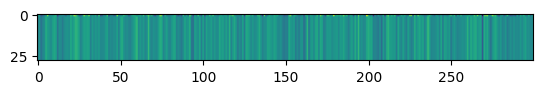

Train Epoch: 20 [800/1136 (69%)]	 KLD Loss: 0.000024 	 NLL Loss: 3113.608887


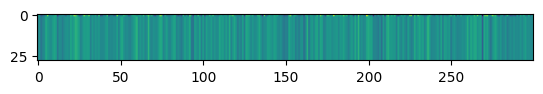

Train Epoch: 20 [960/1136 (83%)]	 KLD Loss: 0.000017 	 NLL Loss: 3111.760986


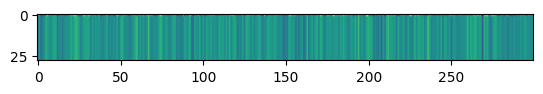

Train Epoch: 20 [1120/1136 (97%)]	 KLD Loss: 0.000023 	 NLL Loss: 3107.479980


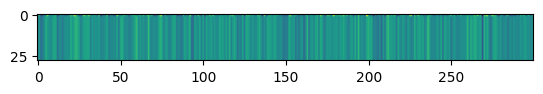

====> Epoch: 20 Average loss: 3107.4051
Train Epoch: 21 [0/1136 (0%)]	 KLD Loss: 0.000042 	 NLL Loss: 3107.043457


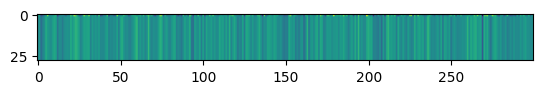

Train Epoch: 21 [160/1136 (14%)]	 KLD Loss: 0.000044 	 NLL Loss: 3109.734131


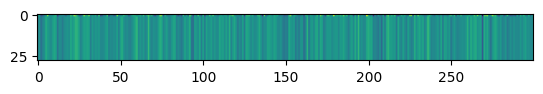

Train Epoch: 21 [320/1136 (28%)]	 KLD Loss: 0.000030 	 NLL Loss: 3106.519287


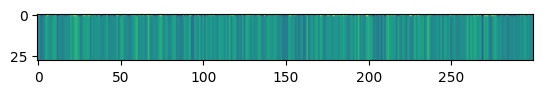

Train Epoch: 21 [480/1136 (42%)]	 KLD Loss: 0.000018 	 NLL Loss: 3109.803711


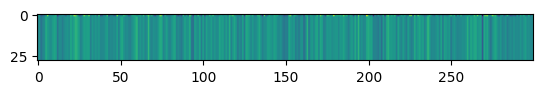

Train Epoch: 21 [640/1136 (56%)]	 KLD Loss: 0.000037 	 NLL Loss: 3108.252441


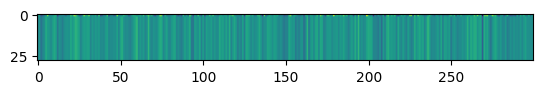

Train Epoch: 21 [800/1136 (69%)]	 KLD Loss: 0.000128 	 NLL Loss: 3105.066650


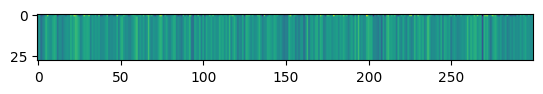

Train Epoch: 21 [960/1136 (83%)]	 KLD Loss: 0.000058 	 NLL Loss: 3105.280273


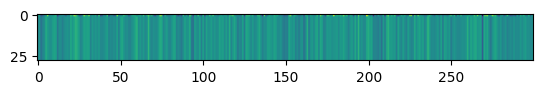

Train Epoch: 21 [1120/1136 (97%)]	 KLD Loss: 0.000057 	 NLL Loss: 3108.379883


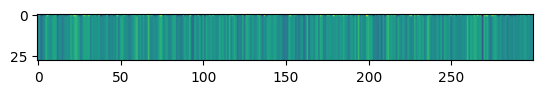

====> Epoch: 21 Average loss: 3107.0889
Train Epoch: 22 [0/1136 (0%)]	 KLD Loss: 0.000123 	 NLL Loss: 3107.786133


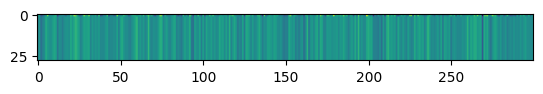

Train Epoch: 22 [160/1136 (14%)]	 KLD Loss: 0.000192 	 NLL Loss: 3105.260010


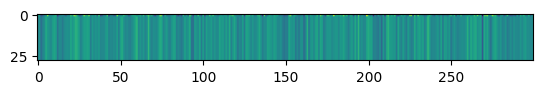

Train Epoch: 22 [320/1136 (28%)]	 KLD Loss: 0.001981 	 NLL Loss: 3107.309326


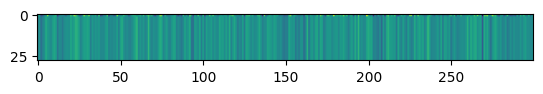

Train Epoch: 22 [480/1136 (42%)]	 KLD Loss: 0.002132 	 NLL Loss: 3107.666992


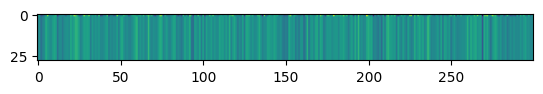

Train Epoch: 22 [640/1136 (56%)]	 KLD Loss: 0.006894 	 NLL Loss: 3104.623047


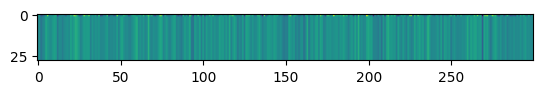

Train Epoch: 22 [800/1136 (69%)]	 KLD Loss: 0.001030 	 NLL Loss: 3106.667480


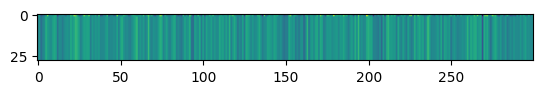

Train Epoch: 22 [960/1136 (83%)]	 KLD Loss: 0.000884 	 NLL Loss: 3106.449707


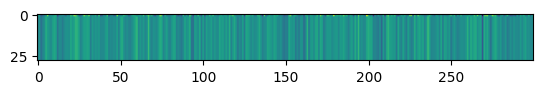

Train Epoch: 22 [1120/1136 (97%)]	 KLD Loss: 0.000900 	 NLL Loss: 3115.973389


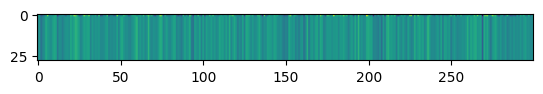

====> Epoch: 22 Average loss: 3107.0484
Train Epoch: 23 [0/1136 (0%)]	 KLD Loss: 0.001502 	 NLL Loss: 3106.801270


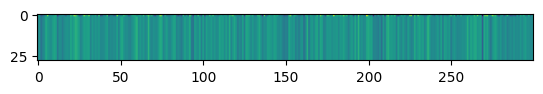

Train Epoch: 23 [160/1136 (14%)]	 KLD Loss: 0.001022 	 NLL Loss: 3106.266357


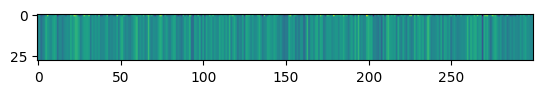

Train Epoch: 23 [320/1136 (28%)]	 KLD Loss: 0.000466 	 NLL Loss: 3106.915039


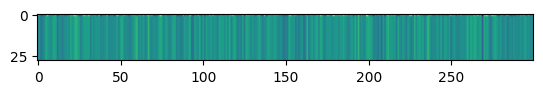

Train Epoch: 23 [480/1136 (42%)]	 KLD Loss: 0.000868 	 NLL Loss: 3108.001953


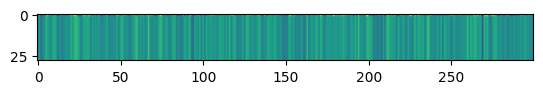

Train Epoch: 23 [640/1136 (56%)]	 KLD Loss: 0.000441 	 NLL Loss: 3097.660400


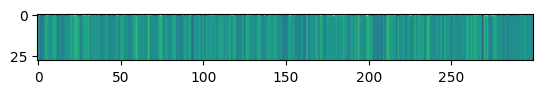

Train Epoch: 23 [800/1136 (69%)]	 KLD Loss: 0.000776 	 NLL Loss: 3107.635498


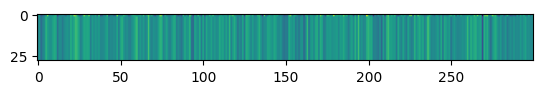

Train Epoch: 23 [960/1136 (83%)]	 KLD Loss: 0.000485 	 NLL Loss: 3107.247559


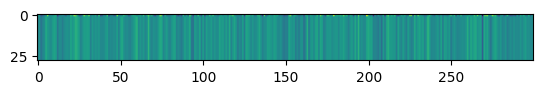

Train Epoch: 23 [1120/1136 (97%)]	 KLD Loss: 0.000287 	 NLL Loss: 3112.720947


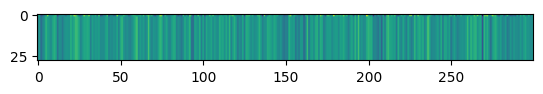

====> Epoch: 23 Average loss: 3107.4398
Train Epoch: 24 [0/1136 (0%)]	 KLD Loss: 0.000280 	 NLL Loss: 3088.965576


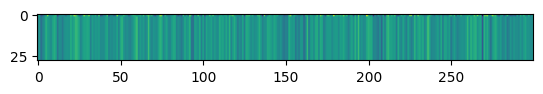

Train Epoch: 24 [160/1136 (14%)]	 KLD Loss: 0.000093 	 NLL Loss: 3108.889160


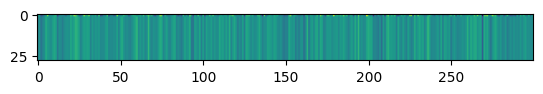

Train Epoch: 24 [320/1136 (28%)]	 KLD Loss: 0.000067 	 NLL Loss: 3106.167480


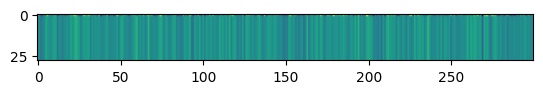

Train Epoch: 24 [480/1136 (42%)]	 KLD Loss: 0.000294 	 NLL Loss: 3106.998779


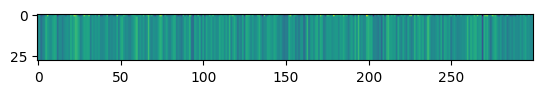

Train Epoch: 24 [640/1136 (56%)]	 KLD Loss: 0.000340 	 NLL Loss: 3105.987793


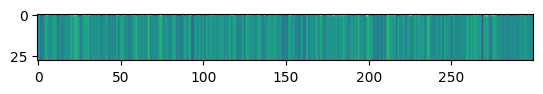

Train Epoch: 24 [800/1136 (69%)]	 KLD Loss: 0.000136 	 NLL Loss: 3108.964355


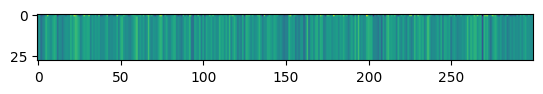

Train Epoch: 24 [960/1136 (83%)]	 KLD Loss: 0.000598 	 NLL Loss: 3107.535400


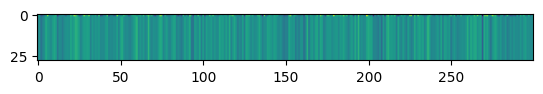

Train Epoch: 24 [1120/1136 (97%)]	 KLD Loss: 0.000237 	 NLL Loss: 3109.859863


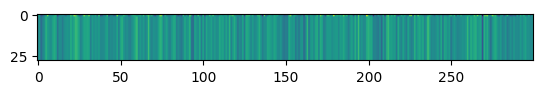

====> Epoch: 24 Average loss: 3107.5477
Train Epoch: 25 [0/1136 (0%)]	 KLD Loss: 0.000595 	 NLL Loss: 3109.062012


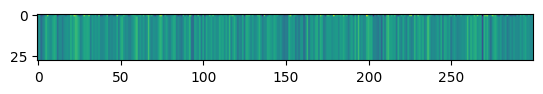

Train Epoch: 25 [160/1136 (14%)]	 KLD Loss: 0.000802 	 NLL Loss: 3105.941406


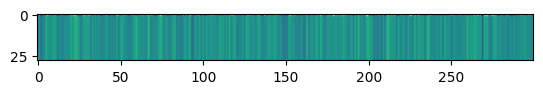

Train Epoch: 25 [320/1136 (28%)]	 KLD Loss: 0.001786 	 NLL Loss: 3105.554199


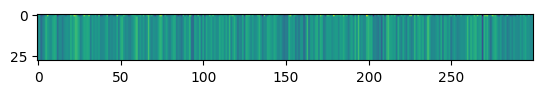

Train Epoch: 25 [480/1136 (42%)]	 KLD Loss: 0.001286 	 NLL Loss: 3111.338623


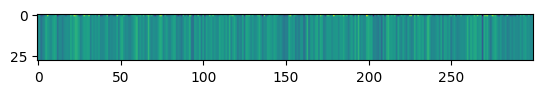

Train Epoch: 25 [640/1136 (56%)]	 KLD Loss: 0.000375 	 NLL Loss: 3114.904297


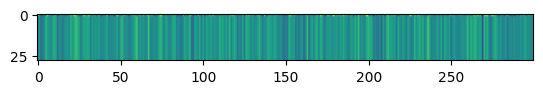

Train Epoch: 25 [800/1136 (69%)]	 KLD Loss: 0.000166 	 NLL Loss: 3108.070312


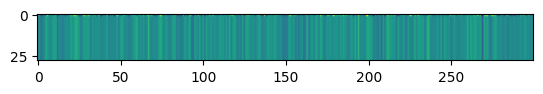

Train Epoch: 25 [960/1136 (83%)]	 KLD Loss: 0.000193 	 NLL Loss: 3102.354980


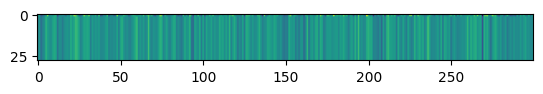

Train Epoch: 25 [1120/1136 (97%)]	 KLD Loss: 0.000674 	 NLL Loss: 3107.520996


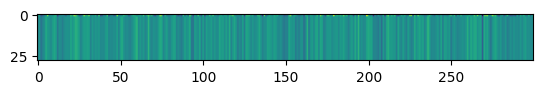

====> Epoch: 25 Average loss: 3107.0666
Train Epoch: 26 [0/1136 (0%)]	 KLD Loss: 0.001968 	 NLL Loss: 3106.024414


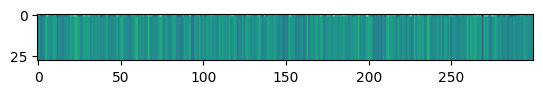

Train Epoch: 26 [160/1136 (14%)]	 KLD Loss: 0.000579 	 NLL Loss: 3104.794922


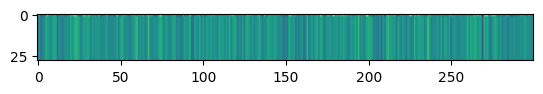

Train Epoch: 26 [320/1136 (28%)]	 KLD Loss: 0.000100 	 NLL Loss: 3106.359375


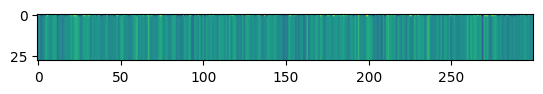

Train Epoch: 26 [480/1136 (42%)]	 KLD Loss: 0.000126 	 NLL Loss: 3100.454102


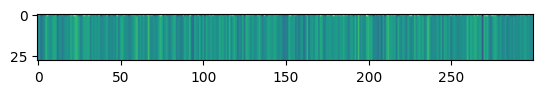

Train Epoch: 26 [640/1136 (56%)]	 KLD Loss: 0.000106 	 NLL Loss: 3105.956787


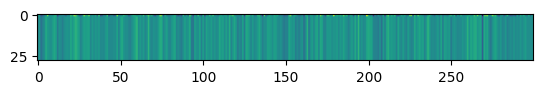

Train Epoch: 26 [800/1136 (69%)]	 KLD Loss: 0.000064 	 NLL Loss: 3107.402344


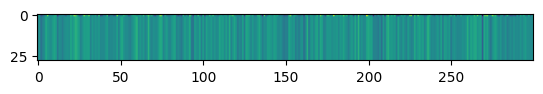

Train Epoch: 26 [960/1136 (83%)]	 KLD Loss: 0.000073 	 NLL Loss: 3107.079590


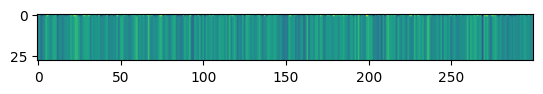

Train Epoch: 26 [1120/1136 (97%)]	 KLD Loss: 0.000106 	 NLL Loss: 3108.763916


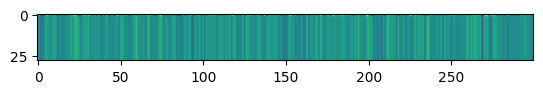

====> Epoch: 26 Average loss: 3107.5681
Train Epoch: 27 [0/1136 (0%)]	 KLD Loss: 0.000393 	 NLL Loss: 3107.429443


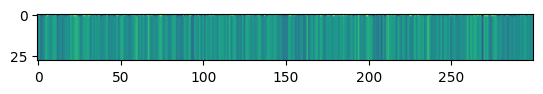

Train Epoch: 27 [160/1136 (14%)]	 KLD Loss: 0.000152 	 NLL Loss: 3107.964844


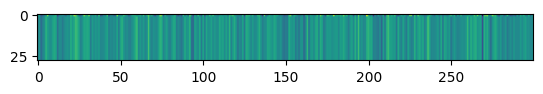

Train Epoch: 27 [320/1136 (28%)]	 KLD Loss: 0.000398 	 NLL Loss: 3108.164062


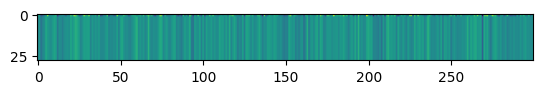

Train Epoch: 27 [480/1136 (42%)]	 KLD Loss: 0.000208 	 NLL Loss: 3116.316895


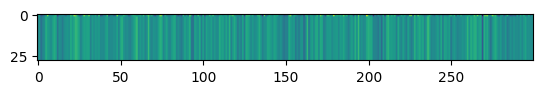

Train Epoch: 27 [640/1136 (56%)]	 KLD Loss: 0.000262 	 NLL Loss: 3105.172852


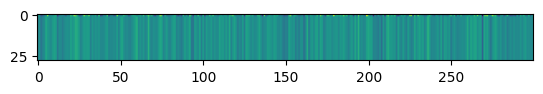

Train Epoch: 27 [800/1136 (69%)]	 KLD Loss: 0.000148 	 NLL Loss: 3108.024414


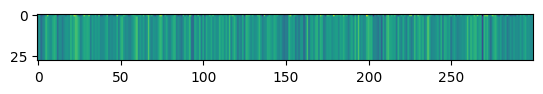

Train Epoch: 27 [960/1136 (83%)]	 KLD Loss: 0.000364 	 NLL Loss: 3108.769043


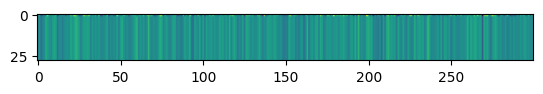

Train Epoch: 27 [1120/1136 (97%)]	 KLD Loss: 0.000230 	 NLL Loss: 3105.926270


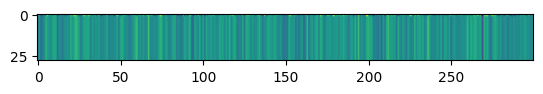

====> Epoch: 27 Average loss: 3107.2530
Train Epoch: 28 [0/1136 (0%)]	 KLD Loss: 0.001045 	 NLL Loss: 3100.423828


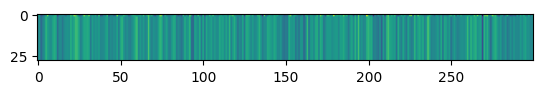

Train Epoch: 28 [160/1136 (14%)]	 KLD Loss: 0.000187 	 NLL Loss: 3106.252197


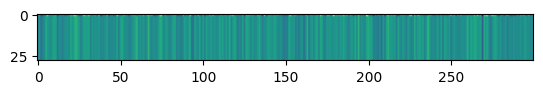

Train Epoch: 28 [320/1136 (28%)]	 KLD Loss: 0.000312 	 NLL Loss: 3099.222168


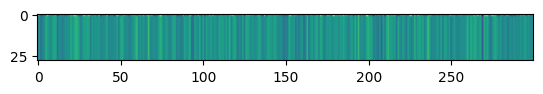

Train Epoch: 28 [480/1136 (42%)]	 KLD Loss: 0.000049 	 NLL Loss: 3108.753418


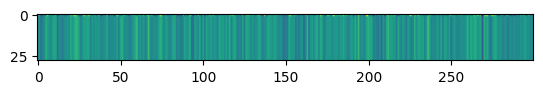

Train Epoch: 28 [640/1136 (56%)]	 KLD Loss: 0.000085 	 NLL Loss: 3108.035156


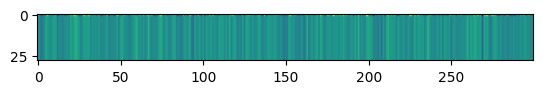

Train Epoch: 28 [800/1136 (69%)]	 KLD Loss: 0.000075 	 NLL Loss: 3101.020752


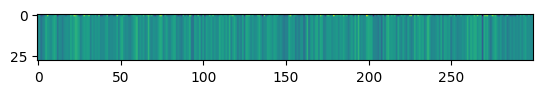

Train Epoch: 28 [960/1136 (83%)]	 KLD Loss: 0.000040 	 NLL Loss: 3107.691895


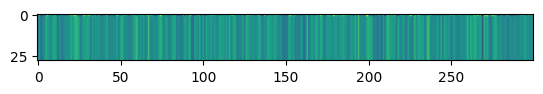

Train Epoch: 28 [1120/1136 (97%)]	 KLD Loss: 0.000120 	 NLL Loss: 3107.661865


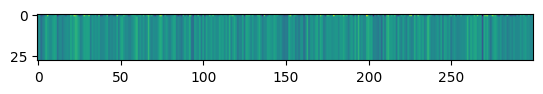

====> Epoch: 28 Average loss: 3106.9300
Train Epoch: 29 [0/1136 (0%)]	 KLD Loss: 0.000181 	 NLL Loss: 3106.118652


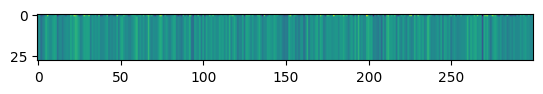

Train Epoch: 29 [160/1136 (14%)]	 KLD Loss: 0.000095 	 NLL Loss: 3107.683105


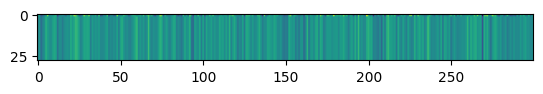

Train Epoch: 29 [320/1136 (28%)]	 KLD Loss: 0.000084 	 NLL Loss: 3107.090820


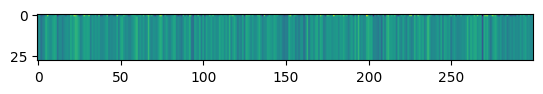

Train Epoch: 29 [480/1136 (42%)]	 KLD Loss: 0.000062 	 NLL Loss: 3106.212646


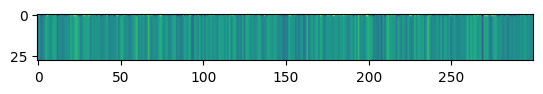

Train Epoch: 29 [640/1136 (56%)]	 KLD Loss: 0.000057 	 NLL Loss: 3126.657471


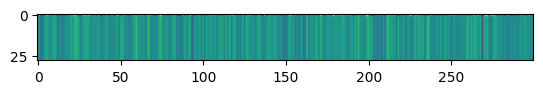

Train Epoch: 29 [800/1136 (69%)]	 KLD Loss: 0.000091 	 NLL Loss: 3109.235352


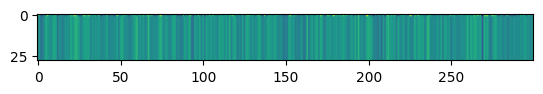

Train Epoch: 29 [960/1136 (83%)]	 KLD Loss: 0.000061 	 NLL Loss: 3108.338379


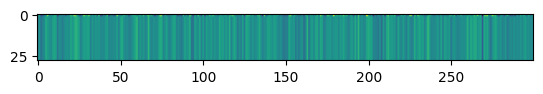

Train Epoch: 29 [1120/1136 (97%)]	 KLD Loss: 0.000035 	 NLL Loss: 3098.799805


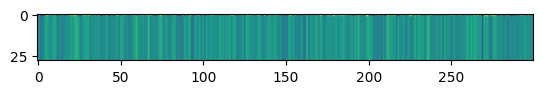

====> Epoch: 29 Average loss: 3107.0814
Train Epoch: 30 [0/1136 (0%)]	 KLD Loss: 0.000076 	 NLL Loss: 3106.510742


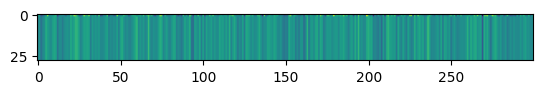

Train Epoch: 30 [160/1136 (14%)]	 KLD Loss: 0.000011 	 NLL Loss: 3115.421387


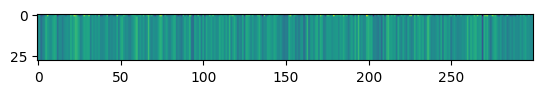

Train Epoch: 30 [320/1136 (28%)]	 KLD Loss: 0.000088 	 NLL Loss: 3105.472656


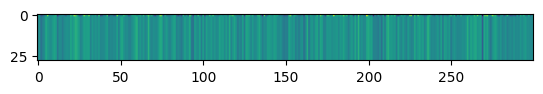

Train Epoch: 30 [480/1136 (42%)]	 KLD Loss: 0.000055 	 NLL Loss: 3107.314209


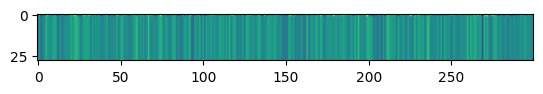

Train Epoch: 30 [640/1136 (56%)]	 KLD Loss: 0.018204 	 NLL Loss: 3109.142578


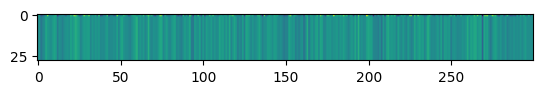

Train Epoch: 30 [800/1136 (69%)]	 KLD Loss: 0.003259 	 NLL Loss: 3110.110840


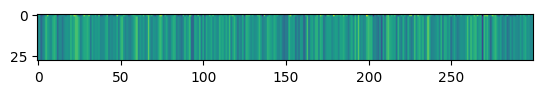

Train Epoch: 30 [960/1136 (83%)]	 KLD Loss: 0.002731 	 NLL Loss: 3111.142822


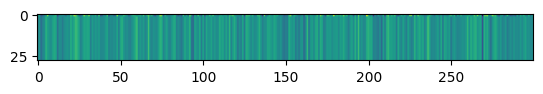

Train Epoch: 30 [1120/1136 (97%)]	 KLD Loss: 0.020987 	 NLL Loss: 3110.677246


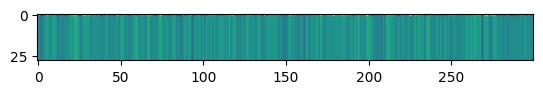

====> Epoch: 30 Average loss: 3107.2636
Train Epoch: 1 [0/1600 (0%)]	 KLD Loss: 4.235032 	 NLL Loss: 3124.077393


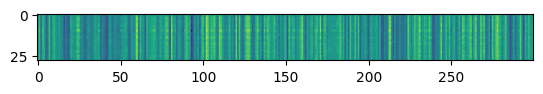

Train Epoch: 1 [160/1600 (10%)]	 KLD Loss: 0.479802 	 NLL Loss: 3111.790527


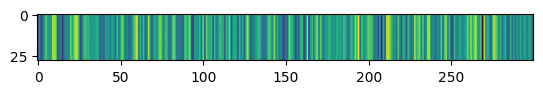

Train Epoch: 1 [320/1600 (20%)]	 KLD Loss: 0.102358 	 NLL Loss: 3124.878662


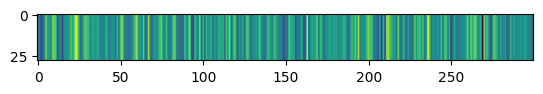

Train Epoch: 1 [480/1600 (30%)]	 KLD Loss: 0.069196 	 NLL Loss: 3097.047363


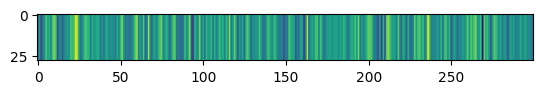

Train Epoch: 1 [640/1600 (40%)]	 KLD Loss: 0.016370 	 NLL Loss: 3098.891357


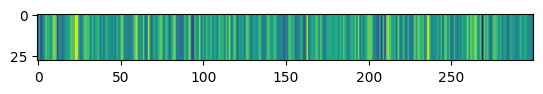

Train Epoch: 1 [800/1600 (50%)]	 KLD Loss: 0.005658 	 NLL Loss: 3114.887695


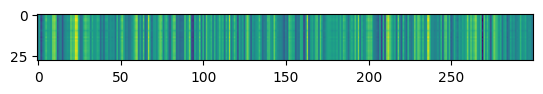

Train Epoch: 1 [960/1600 (59%)]	 KLD Loss: 0.014290 	 NLL Loss: 3110.156250


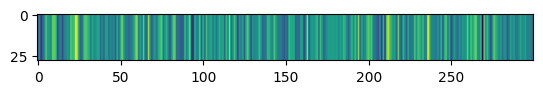

Train Epoch: 1 [1120/1600 (69%)]	 KLD Loss: 0.004690 	 NLL Loss: 3115.449463


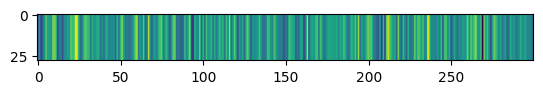

Train Epoch: 1 [1280/1600 (79%)]	 KLD Loss: 0.001277 	 NLL Loss: 3102.340088


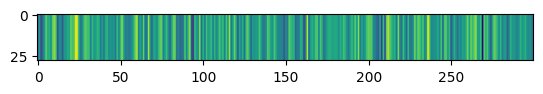

Train Epoch: 1 [1440/1600 (89%)]	 KLD Loss: 0.002202 	 NLL Loss: 3141.195801


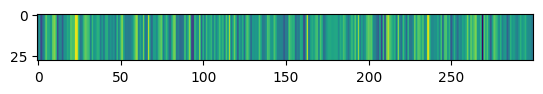

Train Epoch: 1 [1600/1600 (99%)]	 KLD Loss: 0.000648 	 NLL Loss: 769.424072


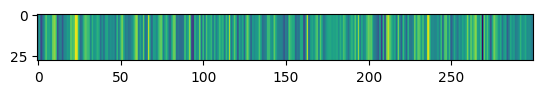

====> Epoch: 1 Average loss: 3110.0360
Train Epoch: 2 [0/1600 (0%)]	 KLD Loss: 0.004151 	 NLL Loss: 3084.333008


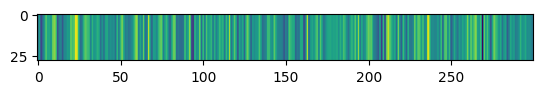

Train Epoch: 2 [160/1600 (10%)]	 KLD Loss: 0.001330 	 NLL Loss: 3100.378906


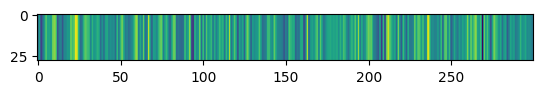

Train Epoch: 2 [320/1600 (20%)]	 KLD Loss: 0.000566 	 NLL Loss: 3111.362305


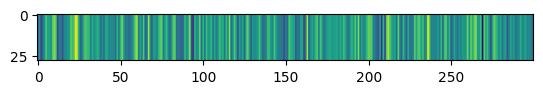

Train Epoch: 2 [480/1600 (30%)]	 KLD Loss: 0.027402 	 NLL Loss: 3109.318359


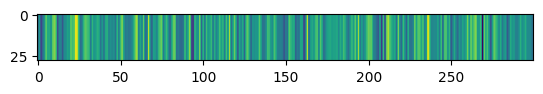

Train Epoch: 2 [640/1600 (40%)]	 KLD Loss: 0.005862 	 NLL Loss: 3105.612549


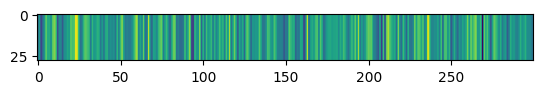

Train Epoch: 2 [800/1600 (50%)]	 KLD Loss: 0.002944 	 NLL Loss: 3115.929688


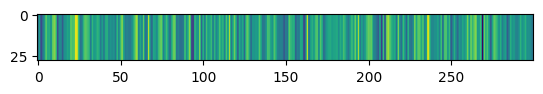

Train Epoch: 2 [960/1600 (59%)]	 KLD Loss: 0.001072 	 NLL Loss: 3116.583008


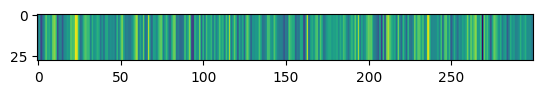

Train Epoch: 2 [1120/1600 (69%)]	 KLD Loss: 0.000244 	 NLL Loss: 3105.238037


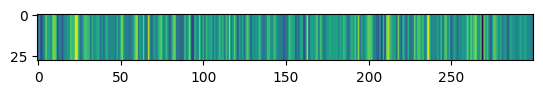

Train Epoch: 2 [1280/1600 (79%)]	 KLD Loss: 0.001516 	 NLL Loss: 3100.650146


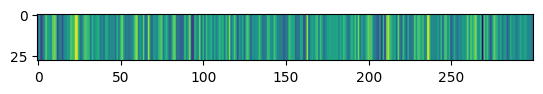

Train Epoch: 2 [1440/1600 (89%)]	 KLD Loss: 0.000193 	 NLL Loss: 3104.267822


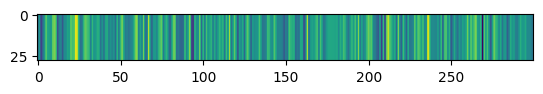

Train Epoch: 2 [1600/1600 (99%)]	 KLD Loss: 0.000198 	 NLL Loss: 777.844971


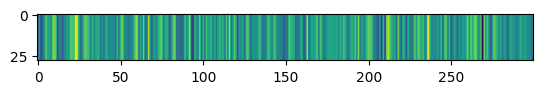

====> Epoch: 2 Average loss: 3109.8463
Train Epoch: 3 [0/1600 (0%)]	 KLD Loss: 0.001168 	 NLL Loss: 3111.426514


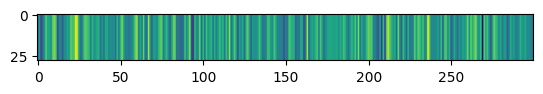

Train Epoch: 3 [160/1600 (10%)]	 KLD Loss: 0.000809 	 NLL Loss: 3107.429199


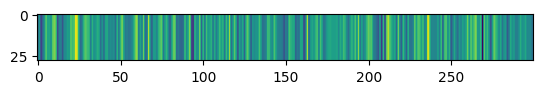

Train Epoch: 3 [320/1600 (20%)]	 KLD Loss: 0.000535 	 NLL Loss: 3103.575439


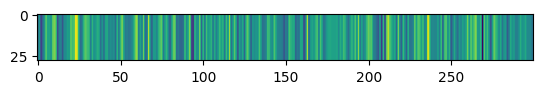

Train Epoch: 3 [480/1600 (30%)]	 KLD Loss: 0.000489 	 NLL Loss: 3120.308350


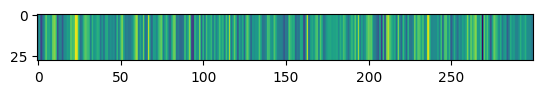

Train Epoch: 3 [640/1600 (40%)]	 KLD Loss: 0.000291 	 NLL Loss: 3098.404297


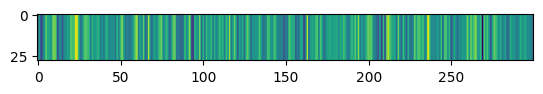

Train Epoch: 3 [800/1600 (50%)]	 KLD Loss: 0.000076 	 NLL Loss: 3103.840576


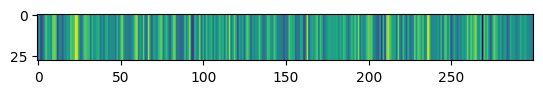

Train Epoch: 3 [960/1600 (59%)]	 KLD Loss: 0.000237 	 NLL Loss: 3090.473145


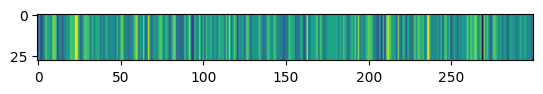

Train Epoch: 3 [1120/1600 (69%)]	 KLD Loss: 0.000211 	 NLL Loss: 3122.800049


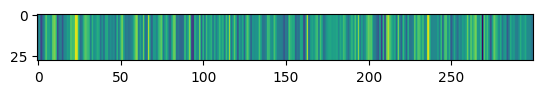

Train Epoch: 3 [1280/1600 (79%)]	 KLD Loss: 0.000096 	 NLL Loss: 3111.303223


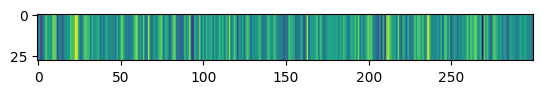

Train Epoch: 3 [1440/1600 (89%)]	 KLD Loss: 0.000108 	 NLL Loss: 3107.462646


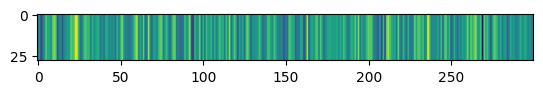

Train Epoch: 3 [1600/1600 (99%)]	 KLD Loss: 0.000037 	 NLL Loss: 778.804871


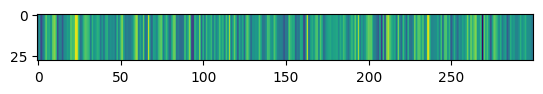

====> Epoch: 3 Average loss: 3109.4822
Train Epoch: 4 [0/1600 (0%)]	 KLD Loss: 0.000179 	 NLL Loss: 3117.758057


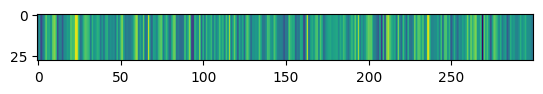

Train Epoch: 4 [160/1600 (10%)]	 KLD Loss: 0.000095 	 NLL Loss: 3102.321777


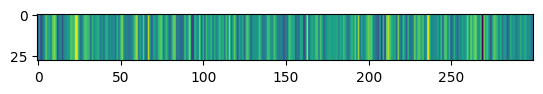

Train Epoch: 4 [320/1600 (20%)]	 KLD Loss: 0.000061 	 NLL Loss: 3113.216553


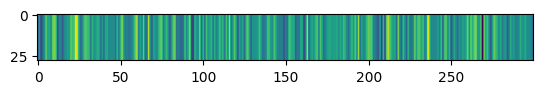

Train Epoch: 4 [480/1600 (30%)]	 KLD Loss: 0.000094 	 NLL Loss: 3098.726562


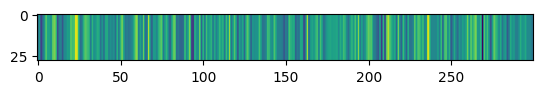

Train Epoch: 4 [640/1600 (40%)]	 KLD Loss: 0.000173 	 NLL Loss: 3102.117188


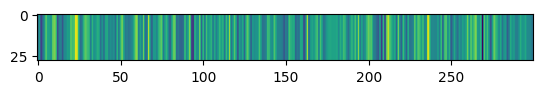

Train Epoch: 4 [800/1600 (50%)]	 KLD Loss: 0.000089 	 NLL Loss: 3099.615967


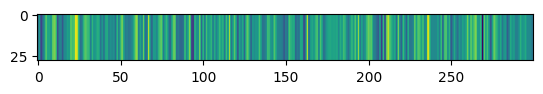

Train Epoch: 4 [960/1600 (59%)]	 KLD Loss: 0.000069 	 NLL Loss: 3119.661133


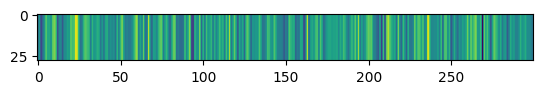

Train Epoch: 4 [1120/1600 (69%)]	 KLD Loss: 0.000121 	 NLL Loss: 3124.117920


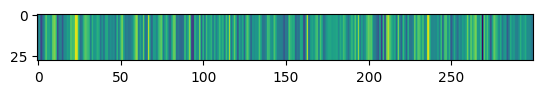

Train Epoch: 4 [1280/1600 (79%)]	 KLD Loss: 0.000119 	 NLL Loss: 3110.457520


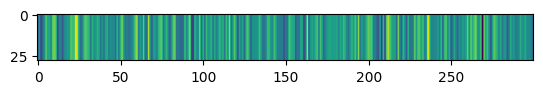

Train Epoch: 4 [1440/1600 (89%)]	 KLD Loss: 0.000227 	 NLL Loss: 3124.668945


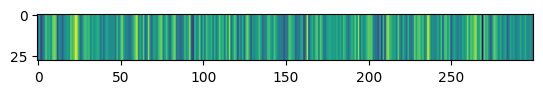

Train Epoch: 4 [1600/1600 (99%)]	 KLD Loss: 0.000021 	 NLL Loss: 775.270081


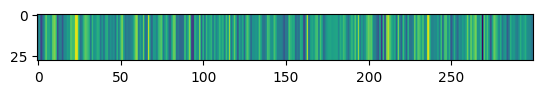

====> Epoch: 4 Average loss: 3109.3488
Train Epoch: 5 [0/1600 (0%)]	 KLD Loss: 0.000092 	 NLL Loss: 3124.715332


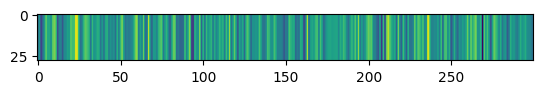

Train Epoch: 5 [160/1600 (10%)]	 KLD Loss: 0.000087 	 NLL Loss: 3104.148682


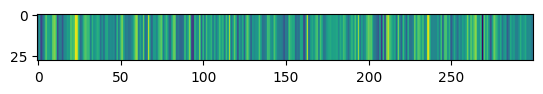

Train Epoch: 5 [320/1600 (20%)]	 KLD Loss: 0.000101 	 NLL Loss: 3107.450195


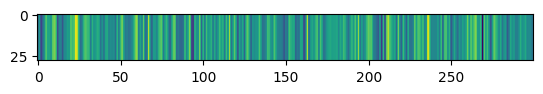

Train Epoch: 5 [480/1600 (30%)]	 KLD Loss: 0.000070 	 NLL Loss: 3116.830078


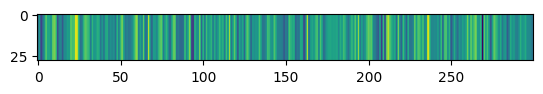

Train Epoch: 5 [640/1600 (40%)]	 KLD Loss: 0.000078 	 NLL Loss: 3127.363770


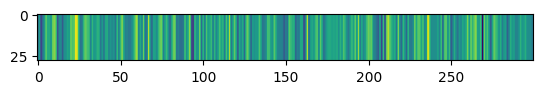

Train Epoch: 5 [800/1600 (50%)]	 KLD Loss: 0.000078 	 NLL Loss: 3131.351074


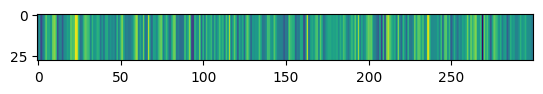

Train Epoch: 5 [960/1600 (59%)]	 KLD Loss: 0.000050 	 NLL Loss: 3111.450928


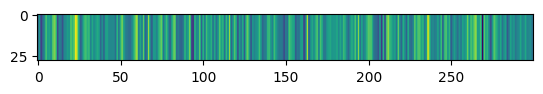

Train Epoch: 5 [1120/1600 (69%)]	 KLD Loss: 0.000129 	 NLL Loss: 3118.683838


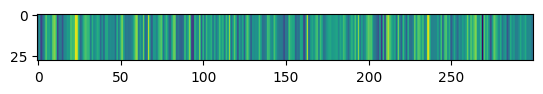

Train Epoch: 5 [1280/1600 (79%)]	 KLD Loss: 0.000058 	 NLL Loss: 3109.234619


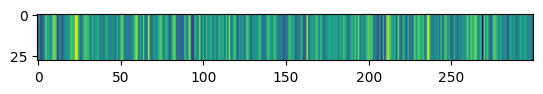

Train Epoch: 5 [1440/1600 (89%)]	 KLD Loss: 0.000127 	 NLL Loss: 3111.912109


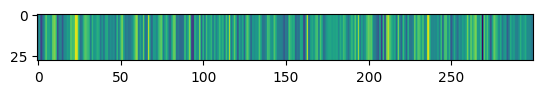

Train Epoch: 5 [1600/1600 (99%)]	 KLD Loss: 0.000018 	 NLL Loss: 777.111328


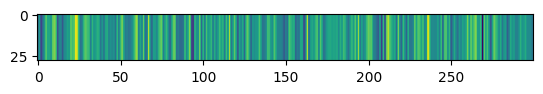

====> Epoch: 5 Average loss: 3109.9557
Train Epoch: 6 [0/1600 (0%)]	 KLD Loss: 0.000126 	 NLL Loss: 3105.557373


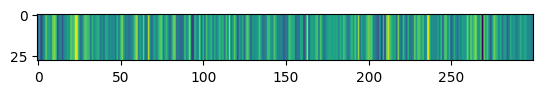

Train Epoch: 6 [160/1600 (10%)]	 KLD Loss: 0.000049 	 NLL Loss: 3100.692627


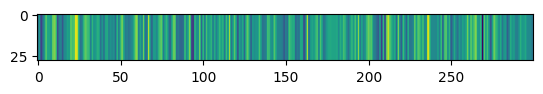

Train Epoch: 6 [320/1600 (20%)]	 KLD Loss: 0.000090 	 NLL Loss: 3108.018066


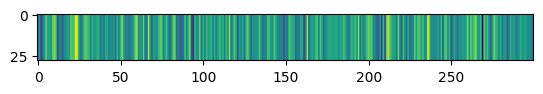

Train Epoch: 6 [480/1600 (30%)]	 KLD Loss: 0.000151 	 NLL Loss: 3108.455322


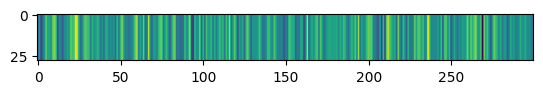

Train Epoch: 6 [640/1600 (40%)]	 KLD Loss: 0.000048 	 NLL Loss: 3106.894775


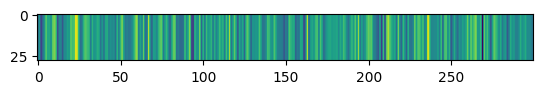

Train Epoch: 6 [800/1600 (50%)]	 KLD Loss: 0.000084 	 NLL Loss: 3104.348633


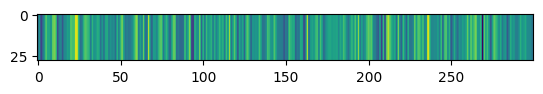

Train Epoch: 6 [960/1600 (59%)]	 KLD Loss: 0.000052 	 NLL Loss: 3107.683594


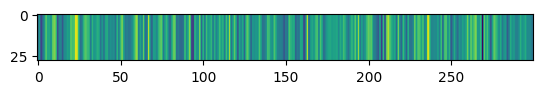

Train Epoch: 6 [1120/1600 (69%)]	 KLD Loss: 0.000158 	 NLL Loss: 3107.838867


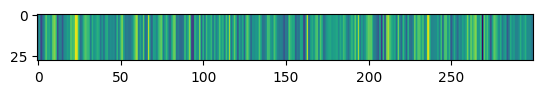

Train Epoch: 6 [1280/1600 (79%)]	 KLD Loss: 0.000103 	 NLL Loss: 3103.497559


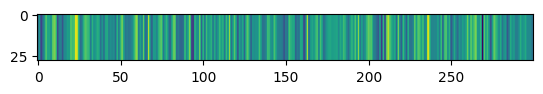

Train Epoch: 6 [1440/1600 (89%)]	 KLD Loss: 0.000068 	 NLL Loss: 3109.162354


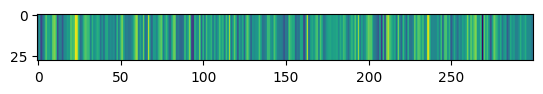

Train Epoch: 6 [1600/1600 (99%)]	 KLD Loss: 0.000018 	 NLL Loss: 776.050720


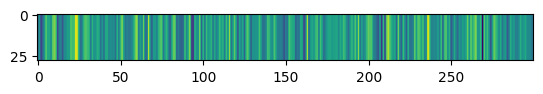

====> Epoch: 6 Average loss: 3108.7463
Train Epoch: 7 [0/1600 (0%)]	 KLD Loss: 0.000219 	 NLL Loss: 3088.128418


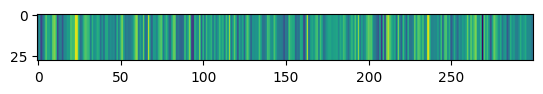

Train Epoch: 7 [160/1600 (10%)]	 KLD Loss: 0.000106 	 NLL Loss: 3131.582275


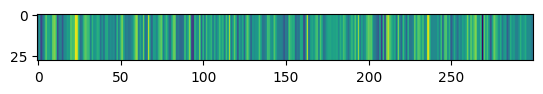

Train Epoch: 7 [320/1600 (20%)]	 KLD Loss: 0.000045 	 NLL Loss: 3102.648193


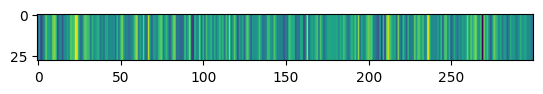

Train Epoch: 7 [480/1600 (30%)]	 KLD Loss: 0.000049 	 NLL Loss: 3092.118408


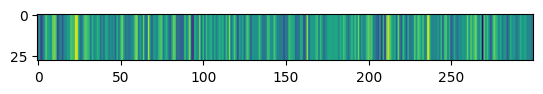

Train Epoch: 7 [640/1600 (40%)]	 KLD Loss: 0.000031 	 NLL Loss: 3101.822266


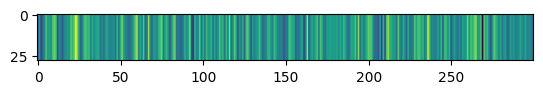

Train Epoch: 7 [800/1600 (50%)]	 KLD Loss: 0.000154 	 NLL Loss: 3099.858887


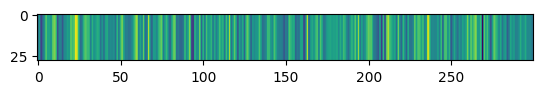

Train Epoch: 7 [960/1600 (59%)]	 KLD Loss: 0.000062 	 NLL Loss: 3109.111572


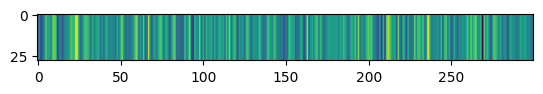

Train Epoch: 7 [1120/1600 (69%)]	 KLD Loss: 0.000043 	 NLL Loss: 3115.468018


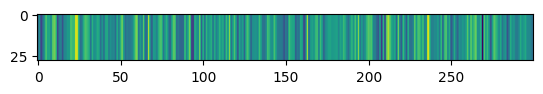

Train Epoch: 7 [1280/1600 (79%)]	 KLD Loss: 0.000034 	 NLL Loss: 3110.180908


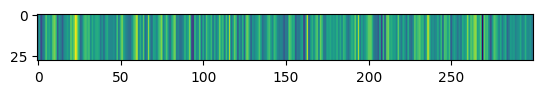

Train Epoch: 7 [1440/1600 (89%)]	 KLD Loss: 0.000054 	 NLL Loss: 3106.553955


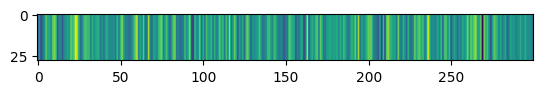

Train Epoch: 7 [1600/1600 (99%)]	 KLD Loss: 0.000014 	 NLL Loss: 780.100037


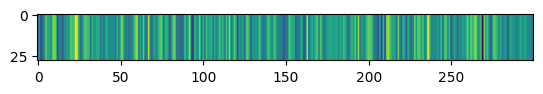

====> Epoch: 7 Average loss: 3108.7696
Train Epoch: 8 [0/1600 (0%)]	 KLD Loss: 0.000090 	 NLL Loss: 3081.953369


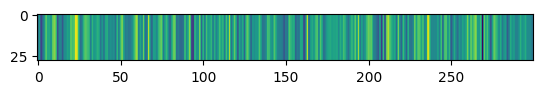

Train Epoch: 8 [160/1600 (10%)]	 KLD Loss: 0.000111 	 NLL Loss: 3124.543701


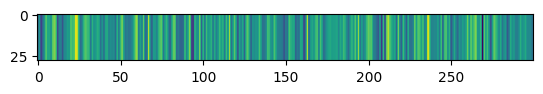

Train Epoch: 8 [320/1600 (20%)]	 KLD Loss: 0.000082 	 NLL Loss: 3112.555176


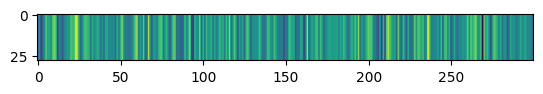

Train Epoch: 8 [480/1600 (30%)]	 KLD Loss: 0.000046 	 NLL Loss: 3118.952393


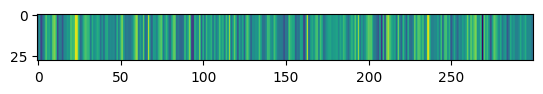

Train Epoch: 8 [640/1600 (40%)]	 KLD Loss: 0.000037 	 NLL Loss: 3103.595947


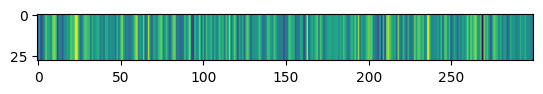

Train Epoch: 8 [800/1600 (50%)]	 KLD Loss: 0.000042 	 NLL Loss: 3105.169189


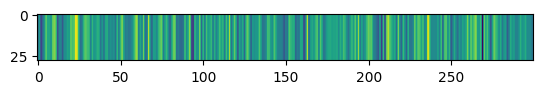

Train Epoch: 8 [960/1600 (59%)]	 KLD Loss: 0.000040 	 NLL Loss: 3110.290039


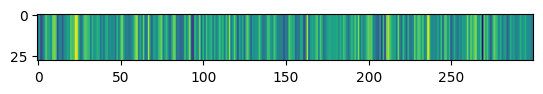

Train Epoch: 8 [1120/1600 (69%)]	 KLD Loss: 0.000060 	 NLL Loss: 3095.211182


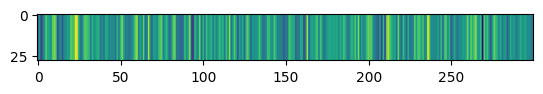

Train Epoch: 8 [1280/1600 (79%)]	 KLD Loss: 0.000044 	 NLL Loss: 3129.410400


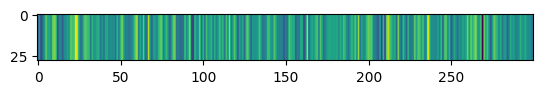

Train Epoch: 8 [1440/1600 (89%)]	 KLD Loss: 0.000072 	 NLL Loss: 3123.796875


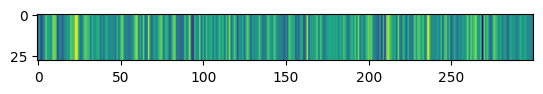

Train Epoch: 8 [1600/1600 (99%)]	 KLD Loss: 0.000011 	 NLL Loss: 772.610352


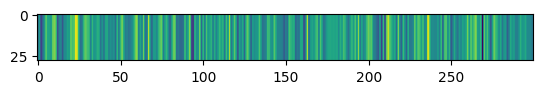

====> Epoch: 8 Average loss: 3110.4277
Train Epoch: 9 [0/1600 (0%)]	 KLD Loss: 0.000053 	 NLL Loss: 3093.364502


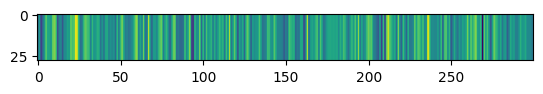

Train Epoch: 9 [160/1600 (10%)]	 KLD Loss: 0.000042 	 NLL Loss: 3118.699463


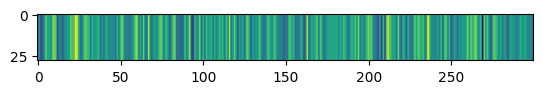

Train Epoch: 9 [320/1600 (20%)]	 KLD Loss: 0.000029 	 NLL Loss: 3107.504395


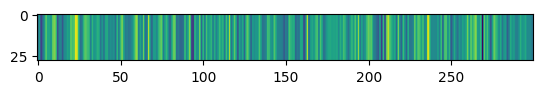

Train Epoch: 9 [480/1600 (30%)]	 KLD Loss: 0.000049 	 NLL Loss: 3123.671387


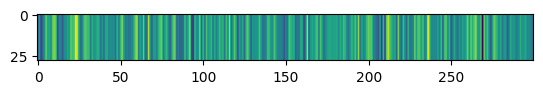

Train Epoch: 9 [640/1600 (40%)]	 KLD Loss: 0.000055 	 NLL Loss: 3112.511230


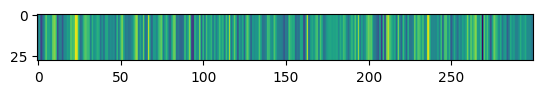

Train Epoch: 9 [800/1600 (50%)]	 KLD Loss: 0.000086 	 NLL Loss: 3099.989258


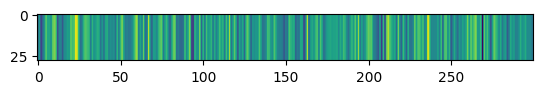

Train Epoch: 9 [960/1600 (59%)]	 KLD Loss: 0.000042 	 NLL Loss: 3120.268555


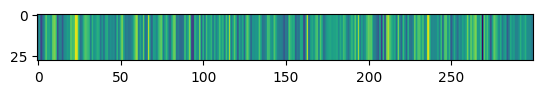

Train Epoch: 9 [1120/1600 (69%)]	 KLD Loss: 0.000201 	 NLL Loss: 3120.194580


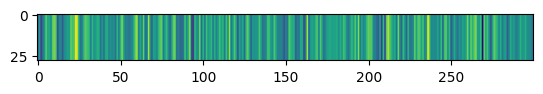

Train Epoch: 9 [1280/1600 (79%)]	 KLD Loss: 0.000137 	 NLL Loss: 3102.287109


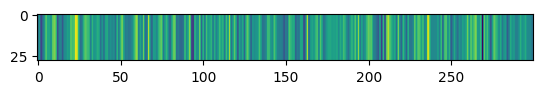

Train Epoch: 9 [1440/1600 (89%)]	 KLD Loss: 0.000093 	 NLL Loss: 3116.002441


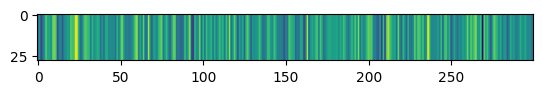

Train Epoch: 9 [1600/1600 (99%)]	 KLD Loss: 0.000021 	 NLL Loss: 778.813232


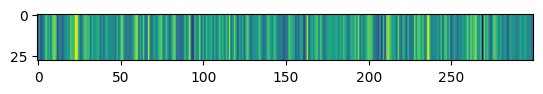

====> Epoch: 9 Average loss: 3109.3348
Train Epoch: 10 [0/1600 (0%)]	 KLD Loss: 0.000073 	 NLL Loss: 3108.321777


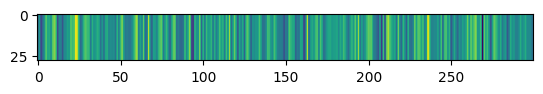

Train Epoch: 10 [160/1600 (10%)]	 KLD Loss: 0.000042 	 NLL Loss: 3118.593506


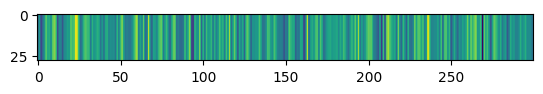

Train Epoch: 10 [320/1600 (20%)]	 KLD Loss: 0.000037 	 NLL Loss: 3112.630371


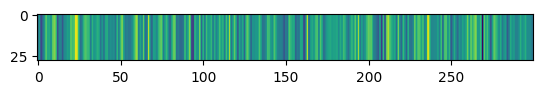

Train Epoch: 10 [480/1600 (30%)]	 KLD Loss: 0.000025 	 NLL Loss: 3105.804688


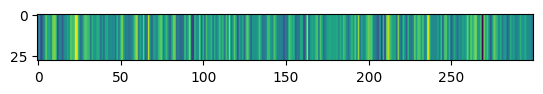

Train Epoch: 10 [640/1600 (40%)]	 KLD Loss: 0.000031 	 NLL Loss: 3102.335205


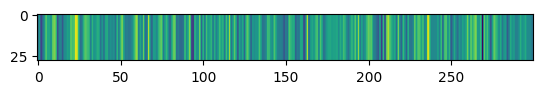

Train Epoch: 10 [800/1600 (50%)]	 KLD Loss: 0.000029 	 NLL Loss: 3095.450684


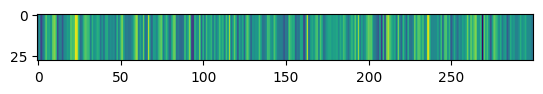

Train Epoch: 10 [960/1600 (59%)]	 KLD Loss: 0.000040 	 NLL Loss: 3126.616943


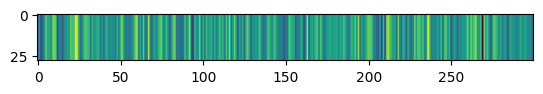

Train Epoch: 10 [1120/1600 (69%)]	 KLD Loss: 0.000035 	 NLL Loss: 3113.044434


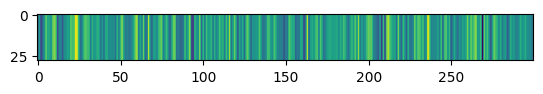

Train Epoch: 10 [1280/1600 (79%)]	 KLD Loss: 0.000033 	 NLL Loss: 3130.055420


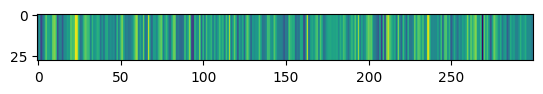

Train Epoch: 10 [1440/1600 (89%)]	 KLD Loss: 0.000047 	 NLL Loss: 3118.625000


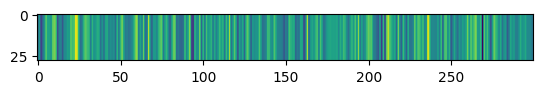

Train Epoch: 10 [1600/1600 (99%)]	 KLD Loss: 0.000008 	 NLL Loss: 776.446655


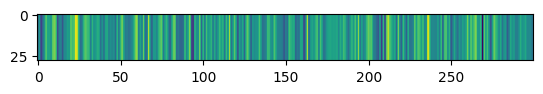

====> Epoch: 10 Average loss: 3109.4558
Train Epoch: 11 [0/1600 (0%)]	 KLD Loss: 0.000069 	 NLL Loss: 3106.785889


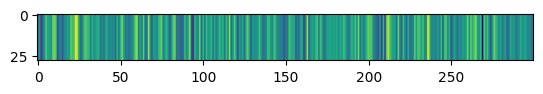

Train Epoch: 11 [160/1600 (10%)]	 KLD Loss: 0.000016 	 NLL Loss: 3115.179199


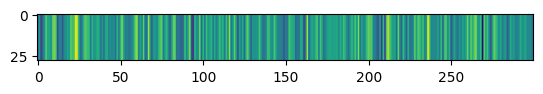

Train Epoch: 11 [320/1600 (20%)]	 KLD Loss: 0.000035 	 NLL Loss: 3107.929199


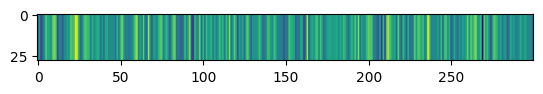

Train Epoch: 11 [480/1600 (30%)]	 KLD Loss: 0.000029 	 NLL Loss: 3107.212158


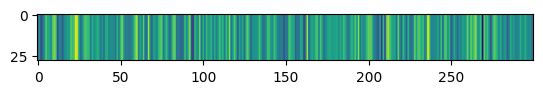

Train Epoch: 11 [640/1600 (40%)]	 KLD Loss: 0.000021 	 NLL Loss: 3099.435791


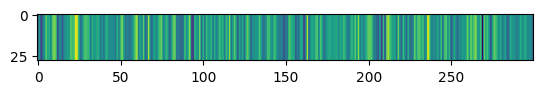

Train Epoch: 11 [800/1600 (50%)]	 KLD Loss: 0.000015 	 NLL Loss: 3119.100342


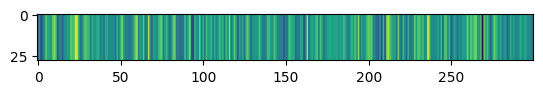

Train Epoch: 11 [960/1600 (59%)]	 KLD Loss: 0.000019 	 NLL Loss: 3101.021484


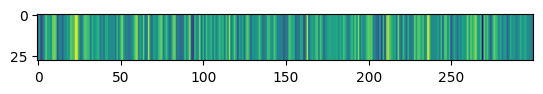

Train Epoch: 11 [1120/1600 (69%)]	 KLD Loss: 0.000046 	 NLL Loss: 3133.418457


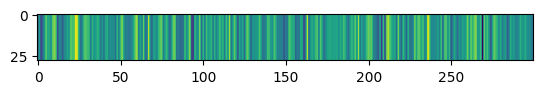

Train Epoch: 11 [1280/1600 (79%)]	 KLD Loss: 0.000017 	 NLL Loss: 3108.396729


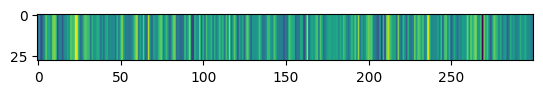

Train Epoch: 11 [1440/1600 (89%)]	 KLD Loss: 0.000018 	 NLL Loss: 3119.066162


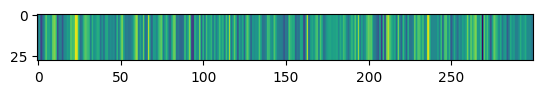

Train Epoch: 11 [1600/1600 (99%)]	 KLD Loss: 0.000009 	 NLL Loss: 774.222107


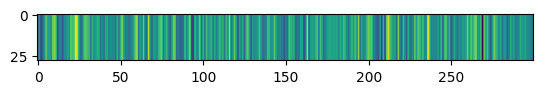

====> Epoch: 11 Average loss: 3108.5690
Train Epoch: 12 [0/1600 (0%)]	 KLD Loss: 0.000059 	 NLL Loss: 3103.780762


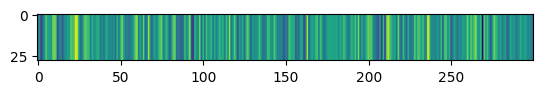

Train Epoch: 12 [160/1600 (10%)]	 KLD Loss: 0.000039 	 NLL Loss: 3103.430664


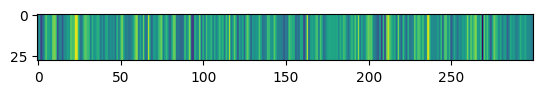

Train Epoch: 12 [320/1600 (20%)]	 KLD Loss: 0.000082 	 NLL Loss: 3102.029541


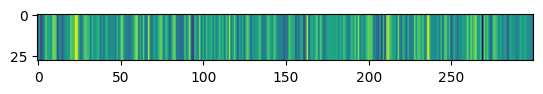

Train Epoch: 12 [480/1600 (30%)]	 KLD Loss: 0.000036 	 NLL Loss: 3105.541260


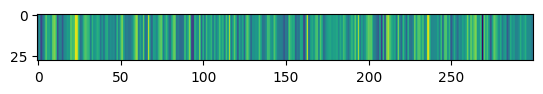

Train Epoch: 12 [640/1600 (40%)]	 KLD Loss: 0.000030 	 NLL Loss: 3104.992188


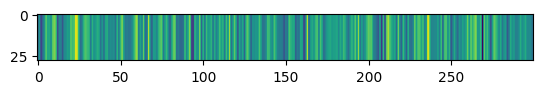

Train Epoch: 12 [800/1600 (50%)]	 KLD Loss: 0.000037 	 NLL Loss: 3112.853760


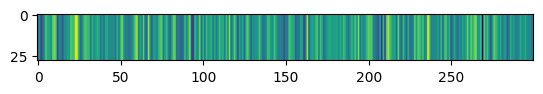

Train Epoch: 12 [960/1600 (59%)]	 KLD Loss: 0.000010 	 NLL Loss: 3110.120117


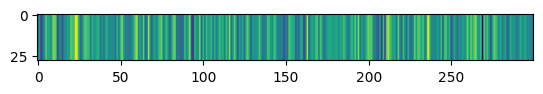

Train Epoch: 12 [1120/1600 (69%)]	 KLD Loss: 0.000020 	 NLL Loss: 3106.587402


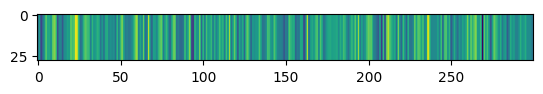

Train Epoch: 12 [1280/1600 (79%)]	 KLD Loss: 0.000020 	 NLL Loss: 3084.033447


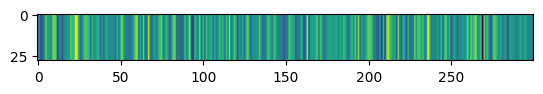

Train Epoch: 12 [1440/1600 (89%)]	 KLD Loss: 0.000021 	 NLL Loss: 3116.692139


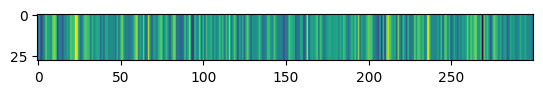

Train Epoch: 12 [1600/1600 (99%)]	 KLD Loss: 0.000005 	 NLL Loss: 772.918884


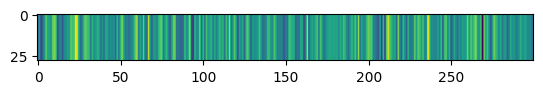

====> Epoch: 12 Average loss: 3109.3619
Train Epoch: 13 [0/1600 (0%)]	 KLD Loss: 0.000078 	 NLL Loss: 3092.711426


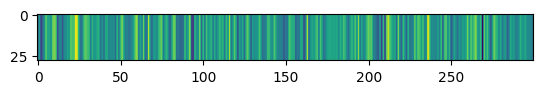

Train Epoch: 13 [160/1600 (10%)]	 KLD Loss: 0.000085 	 NLL Loss: 3082.986084


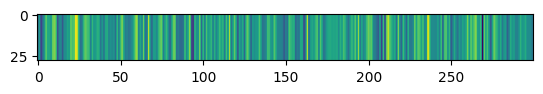

Train Epoch: 13 [320/1600 (20%)]	 KLD Loss: 0.000041 	 NLL Loss: 3130.561035


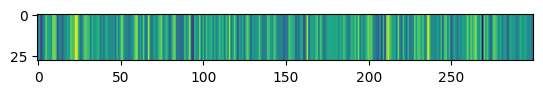

Train Epoch: 13 [480/1600 (30%)]	 KLD Loss: 0.000014 	 NLL Loss: 3102.233643


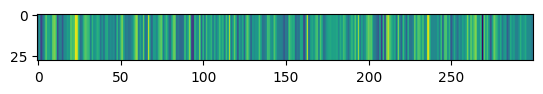

Train Epoch: 13 [640/1600 (40%)]	 KLD Loss: 0.000014 	 NLL Loss: 3089.781006


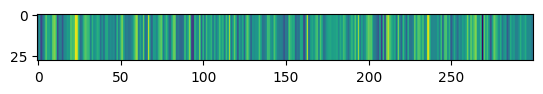

Train Epoch: 13 [800/1600 (50%)]	 KLD Loss: 0.000008 	 NLL Loss: 3109.439941


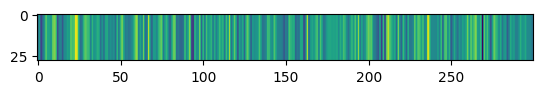

Train Epoch: 13 [960/1600 (59%)]	 KLD Loss: 0.000007 	 NLL Loss: 3106.581543


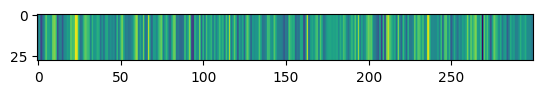

Train Epoch: 13 [1120/1600 (69%)]	 KLD Loss: 0.000013 	 NLL Loss: 3110.528564


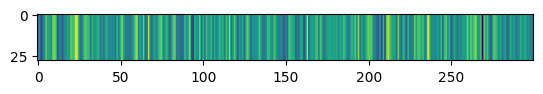

Train Epoch: 13 [1280/1600 (79%)]	 KLD Loss: 0.000015 	 NLL Loss: 3115.376709


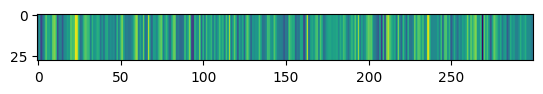

Train Epoch: 13 [1440/1600 (89%)]	 KLD Loss: 0.000012 	 NLL Loss: 3094.896240


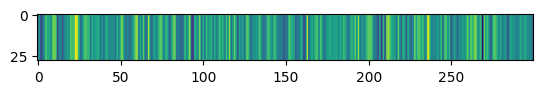

Train Epoch: 13 [1600/1600 (99%)]	 KLD Loss: 0.000003 	 NLL Loss: 777.801331


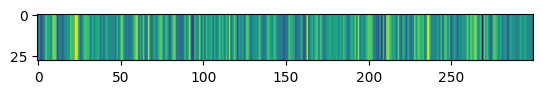

====> Epoch: 13 Average loss: 3109.1161
Train Epoch: 14 [0/1600 (0%)]	 KLD Loss: 0.000047 	 NLL Loss: 3120.431152


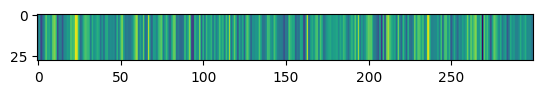

Train Epoch: 14 [160/1600 (10%)]	 KLD Loss: 0.000065 	 NLL Loss: 3110.701172


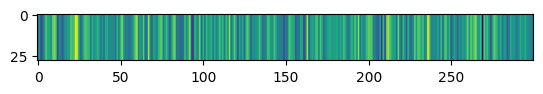

Train Epoch: 14 [320/1600 (20%)]	 KLD Loss: 0.000007 	 NLL Loss: 3107.534668


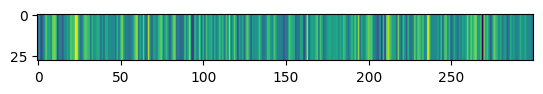

Train Epoch: 14 [480/1600 (30%)]	 KLD Loss: 0.000034 	 NLL Loss: 3110.025146


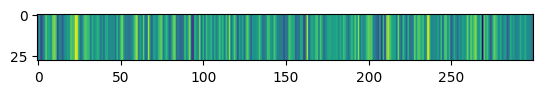

Train Epoch: 14 [640/1600 (40%)]	 KLD Loss: 0.000114 	 NLL Loss: 3121.201660


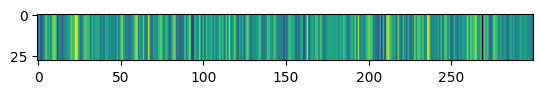

Train Epoch: 14 [800/1600 (50%)]	 KLD Loss: 0.000031 	 NLL Loss: 3139.670654


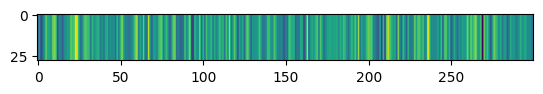

Train Epoch: 14 [960/1600 (59%)]	 KLD Loss: 0.000013 	 NLL Loss: 3102.814209


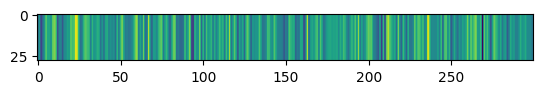

Train Epoch: 14 [1120/1600 (69%)]	 KLD Loss: 0.000020 	 NLL Loss: 3115.364014


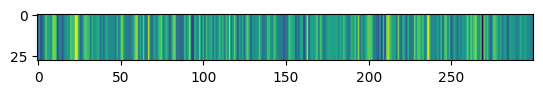

Train Epoch: 14 [1280/1600 (79%)]	 KLD Loss: 0.000008 	 NLL Loss: 3113.763672


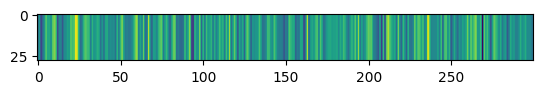

Train Epoch: 14 [1440/1600 (89%)]	 KLD Loss: 0.000006 	 NLL Loss: 3099.061035


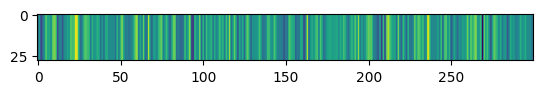

Train Epoch: 14 [1600/1600 (99%)]	 KLD Loss: 0.000005 	 NLL Loss: 776.329529


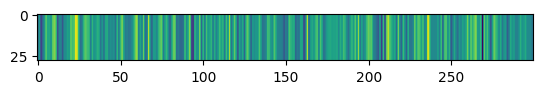

====> Epoch: 14 Average loss: 3109.8362
Train Epoch: 15 [0/1600 (0%)]	 KLD Loss: 0.000028 	 NLL Loss: 3112.148926


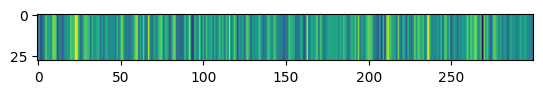

Train Epoch: 15 [160/1600 (10%)]	 KLD Loss: 0.000010 	 NLL Loss: 3105.843750


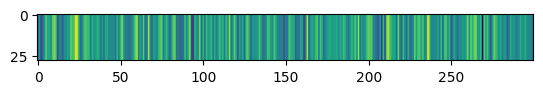

Train Epoch: 15 [320/1600 (20%)]	 KLD Loss: 0.000022 	 NLL Loss: 3110.179443


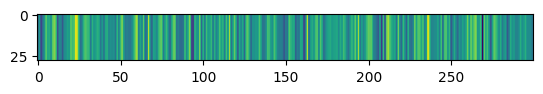

Train Epoch: 15 [480/1600 (30%)]	 KLD Loss: 0.000022 	 NLL Loss: 3113.545898


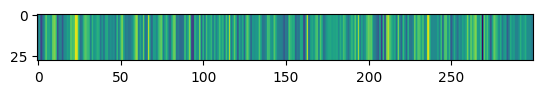

Train Epoch: 15 [640/1600 (40%)]	 KLD Loss: 0.000022 	 NLL Loss: 3118.389893


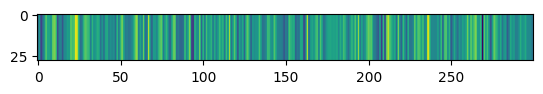

Train Epoch: 15 [800/1600 (50%)]	 KLD Loss: 0.000041 	 NLL Loss: 3106.243896


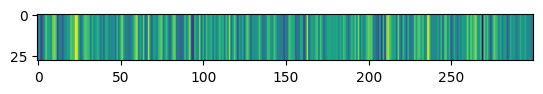

Train Epoch: 15 [960/1600 (59%)]	 KLD Loss: 0.000015 	 NLL Loss: 3098.939697


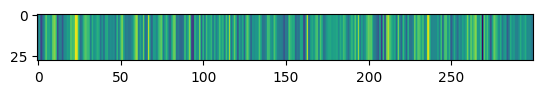

Train Epoch: 15 [1120/1600 (69%)]	 KLD Loss: 0.000012 	 NLL Loss: 3127.670410


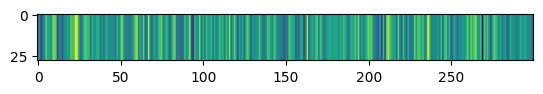

Train Epoch: 15 [1280/1600 (79%)]	 KLD Loss: 0.000030 	 NLL Loss: 3134.865234


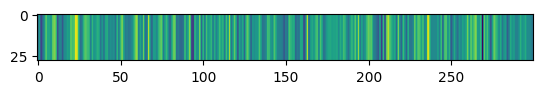

Train Epoch: 15 [1440/1600 (89%)]	 KLD Loss: 0.000010 	 NLL Loss: 3109.448730


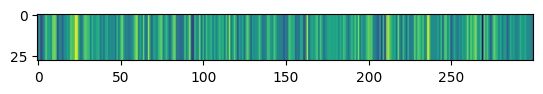

Train Epoch: 15 [1600/1600 (99%)]	 KLD Loss: 0.000004 	 NLL Loss: 777.244568


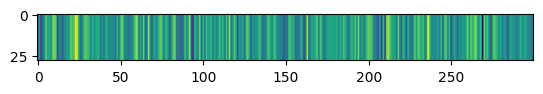

====> Epoch: 15 Average loss: 3109.4055
Train Epoch: 16 [0/1600 (0%)]	 KLD Loss: 0.000016 	 NLL Loss: 3098.233643


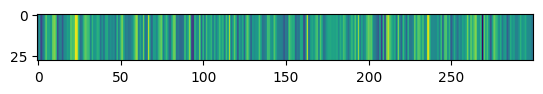

Train Epoch: 16 [160/1600 (10%)]	 KLD Loss: 0.000010 	 NLL Loss: 3089.902588


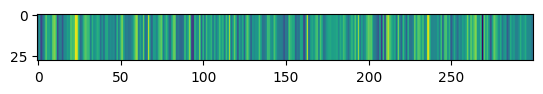

Train Epoch: 16 [320/1600 (20%)]	 KLD Loss: 0.000005 	 NLL Loss: 3107.975098


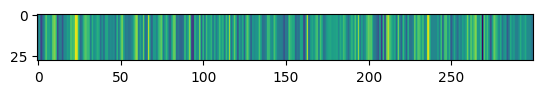

Train Epoch: 16 [480/1600 (30%)]	 KLD Loss: 0.000070 	 NLL Loss: 3100.248291


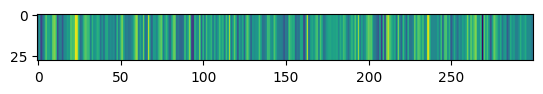

Train Epoch: 16 [640/1600 (40%)]	 KLD Loss: 0.000164 	 NLL Loss: 3108.557861


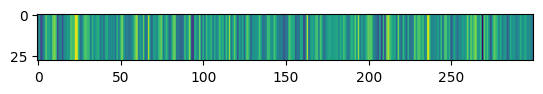

Train Epoch: 16 [800/1600 (50%)]	 KLD Loss: 0.000018 	 NLL Loss: 3111.332031


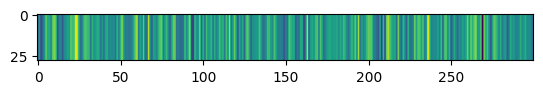

Train Epoch: 16 [960/1600 (59%)]	 KLD Loss: 0.000092 	 NLL Loss: 3100.264648


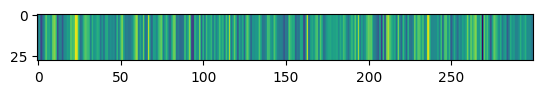

Train Epoch: 16 [1120/1600 (69%)]	 KLD Loss: 0.000148 	 NLL Loss: 3111.567139


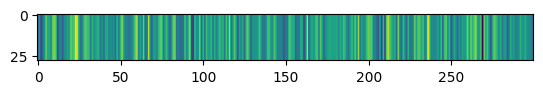

Train Epoch: 16 [1280/1600 (79%)]	 KLD Loss: 0.000070 	 NLL Loss: 3120.060059


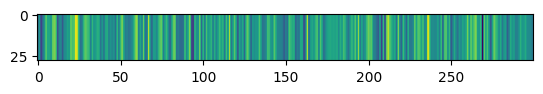

Train Epoch: 16 [1440/1600 (89%)]	 KLD Loss: 0.000020 	 NLL Loss: 3099.784180


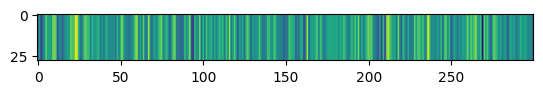

Train Epoch: 16 [1600/1600 (99%)]	 KLD Loss: 0.000013 	 NLL Loss: 776.016113


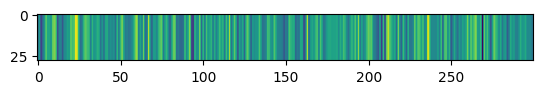

====> Epoch: 16 Average loss: 3110.1747
Train Epoch: 17 [0/1600 (0%)]	 KLD Loss: 0.000011 	 NLL Loss: 3107.020996


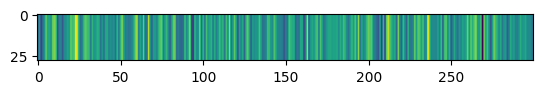

Train Epoch: 17 [160/1600 (10%)]	 KLD Loss: 0.000048 	 NLL Loss: 3115.937012


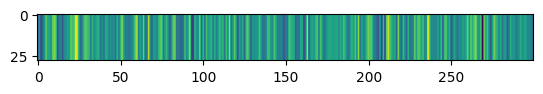

Train Epoch: 17 [320/1600 (20%)]	 KLD Loss: 0.000011 	 NLL Loss: 3121.978027


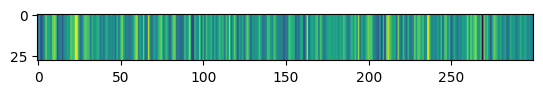

Train Epoch: 17 [480/1600 (30%)]	 KLD Loss: 0.000019 	 NLL Loss: 3115.458252


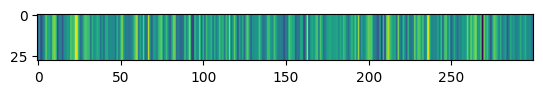

Train Epoch: 17 [640/1600 (40%)]	 KLD Loss: 0.000009 	 NLL Loss: 3113.645996


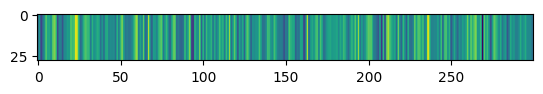

Train Epoch: 17 [800/1600 (50%)]	 KLD Loss: 0.000005 	 NLL Loss: 3107.691895


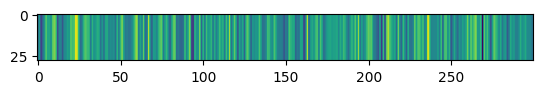

Train Epoch: 17 [960/1600 (59%)]	 KLD Loss: 0.000003 	 NLL Loss: 3112.793213


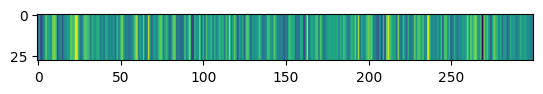

Train Epoch: 17 [1120/1600 (69%)]	 KLD Loss: 0.000008 	 NLL Loss: 3108.860840


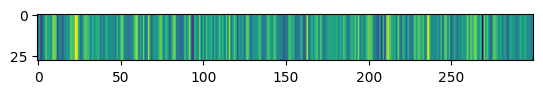

Train Epoch: 17 [1280/1600 (79%)]	 KLD Loss: 0.000006 	 NLL Loss: 3101.881836


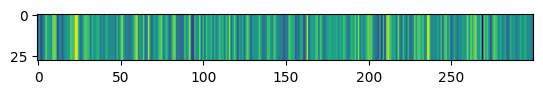

Train Epoch: 17 [1440/1600 (89%)]	 KLD Loss: 0.000013 	 NLL Loss: 3087.146729


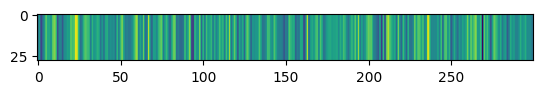

Train Epoch: 17 [1600/1600 (99%)]	 KLD Loss: 0.000003 	 NLL Loss: 782.112976


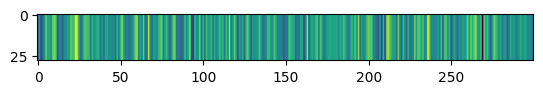

====> Epoch: 17 Average loss: 3109.6415
Train Epoch: 18 [0/1600 (0%)]	 KLD Loss: 0.000010 	 NLL Loss: 3136.672363


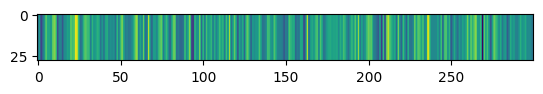

Train Epoch: 18 [160/1600 (10%)]	 KLD Loss: 0.000006 	 NLL Loss: 3105.714355


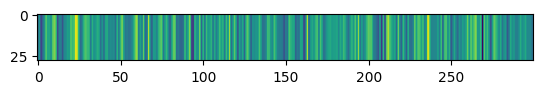

Train Epoch: 18 [320/1600 (20%)]	 KLD Loss: 0.000016 	 NLL Loss: 3114.759277


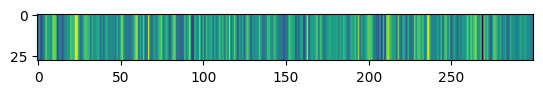

Train Epoch: 18 [480/1600 (30%)]	 KLD Loss: 0.000019 	 NLL Loss: 3113.935791


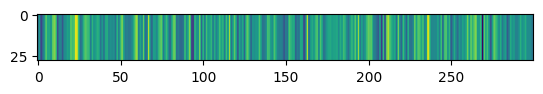

Train Epoch: 18 [640/1600 (40%)]	 KLD Loss: 0.000010 	 NLL Loss: 3113.308838


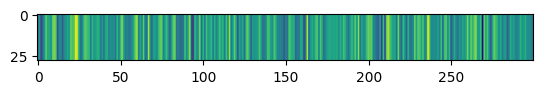

Train Epoch: 18 [800/1600 (50%)]	 KLD Loss: 0.000004 	 NLL Loss: 3105.955322


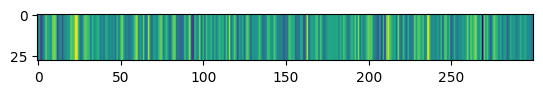

Train Epoch: 18 [960/1600 (59%)]	 KLD Loss: 0.000007 	 NLL Loss: 3100.669678


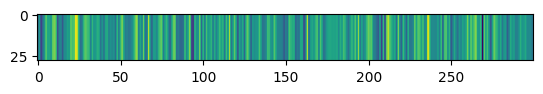

Train Epoch: 18 [1120/1600 (69%)]	 KLD Loss: 0.000006 	 NLL Loss: 3108.759033


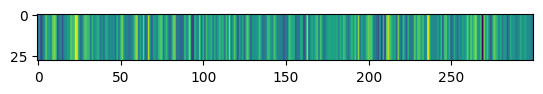

Train Epoch: 18 [1280/1600 (79%)]	 KLD Loss: 0.000005 	 NLL Loss: 3088.555176


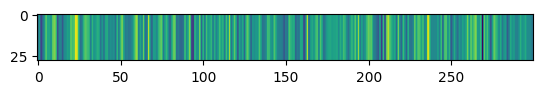

Train Epoch: 18 [1440/1600 (89%)]	 KLD Loss: 0.000031 	 NLL Loss: 3108.800293


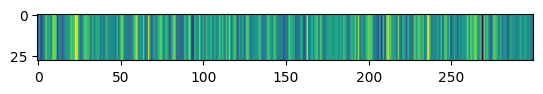

Train Epoch: 18 [1600/1600 (99%)]	 KLD Loss: 0.000001 	 NLL Loss: 774.916504


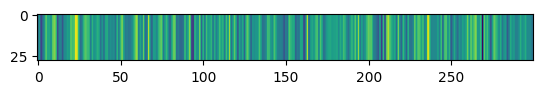

====> Epoch: 18 Average loss: 3110.6917
Train Epoch: 19 [0/1600 (0%)]	 KLD Loss: 0.000021 	 NLL Loss: 3096.601562


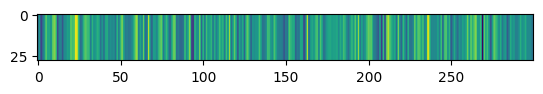

Train Epoch: 19 [160/1600 (10%)]	 KLD Loss: 0.000035 	 NLL Loss: 3104.572266


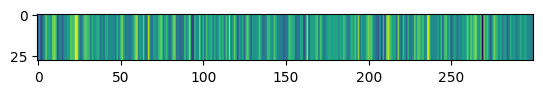

Train Epoch: 19 [320/1600 (20%)]	 KLD Loss: 0.000008 	 NLL Loss: 3117.685547


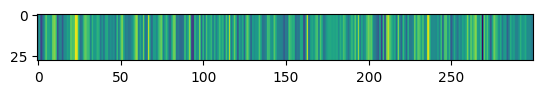

Train Epoch: 19 [480/1600 (30%)]	 KLD Loss: 0.000014 	 NLL Loss: 3124.020508


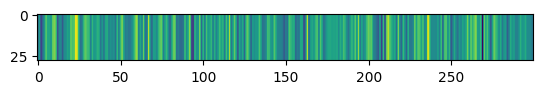

Train Epoch: 19 [640/1600 (40%)]	 KLD Loss: 0.000012 	 NLL Loss: 3116.659668


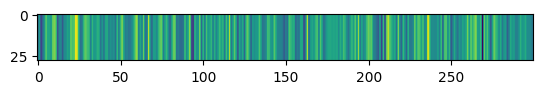

Train Epoch: 19 [800/1600 (50%)]	 KLD Loss: 0.000005 	 NLL Loss: 3108.384277


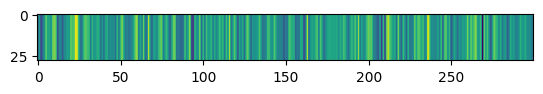

Train Epoch: 19 [960/1600 (59%)]	 KLD Loss: 0.000020 	 NLL Loss: 3126.580811


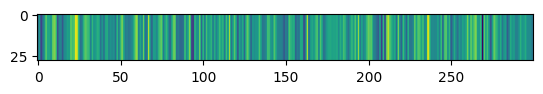

Train Epoch: 19 [1120/1600 (69%)]	 KLD Loss: 0.000014 	 NLL Loss: 3101.419922


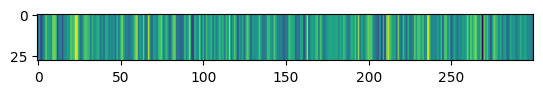

Train Epoch: 19 [1280/1600 (79%)]	 KLD Loss: 0.000004 	 NLL Loss: 3096.301758


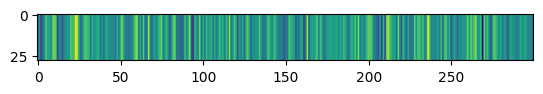

Train Epoch: 19 [1440/1600 (89%)]	 KLD Loss: 0.000010 	 NLL Loss: 3110.462402


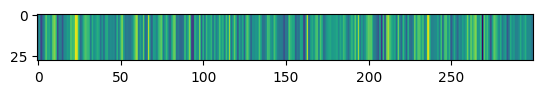

Train Epoch: 19 [1600/1600 (99%)]	 KLD Loss: 0.000003 	 NLL Loss: 777.146301


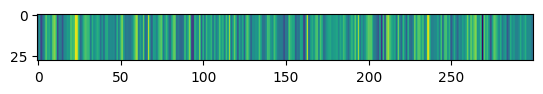

====> Epoch: 19 Average loss: 3108.9257
Train Epoch: 20 [0/1600 (0%)]	 KLD Loss: 0.000007 	 NLL Loss: 3110.789795


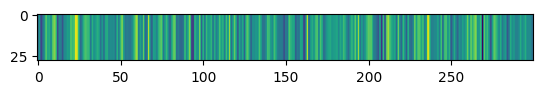

Train Epoch: 20 [160/1600 (10%)]	 KLD Loss: 0.000044 	 NLL Loss: 3107.417725


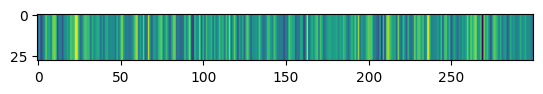

Train Epoch: 20 [320/1600 (20%)]	 KLD Loss: 0.000051 	 NLL Loss: 3111.440674


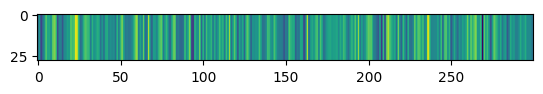

Train Epoch: 20 [480/1600 (30%)]	 KLD Loss: 0.000127 	 NLL Loss: 3108.725586


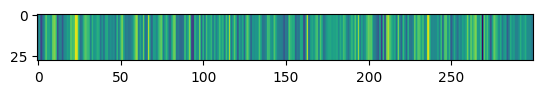

Train Epoch: 20 [640/1600 (40%)]	 KLD Loss: 0.000016 	 NLL Loss: 3109.849365


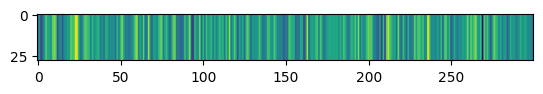

Train Epoch: 20 [800/1600 (50%)]	 KLD Loss: 0.000105 	 NLL Loss: 3125.606689


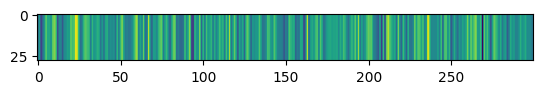

Train Epoch: 20 [960/1600 (59%)]	 KLD Loss: 0.000030 	 NLL Loss: 3115.864014


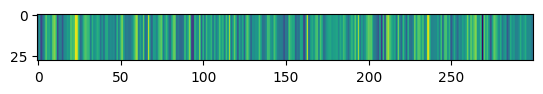

Train Epoch: 20 [1120/1600 (69%)]	 KLD Loss: 0.000013 	 NLL Loss: 3120.190430


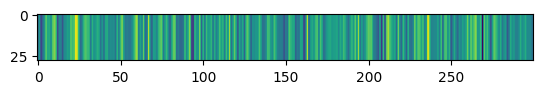

Train Epoch: 20 [1280/1600 (79%)]	 KLD Loss: 0.000024 	 NLL Loss: 3116.548096


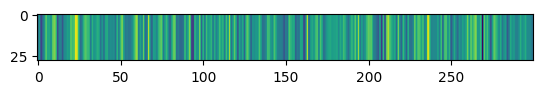

Train Epoch: 20 [1440/1600 (89%)]	 KLD Loss: 0.000166 	 NLL Loss: 3115.591309


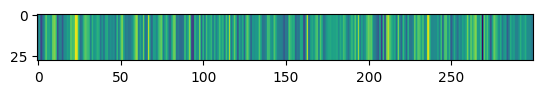

Train Epoch: 20 [1600/1600 (99%)]	 KLD Loss: 0.000003 	 NLL Loss: 778.533142


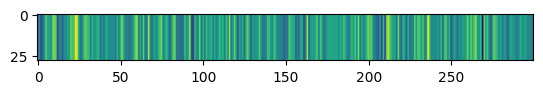

====> Epoch: 20 Average loss: 3109.0769
Train Epoch: 21 [0/1600 (0%)]	 KLD Loss: 0.000368 	 NLL Loss: 3107.109863


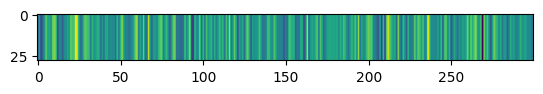

Train Epoch: 21 [160/1600 (10%)]	 KLD Loss: 0.000023 	 NLL Loss: 3114.837891


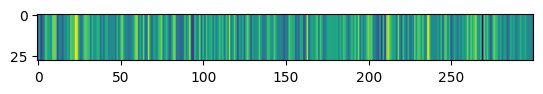

Train Epoch: 21 [320/1600 (20%)]	 KLD Loss: 0.000032 	 NLL Loss: 3104.316162


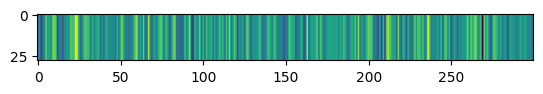

Train Epoch: 21 [480/1600 (30%)]	 KLD Loss: 0.000034 	 NLL Loss: 3106.948486


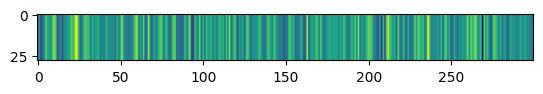

Train Epoch: 21 [640/1600 (40%)]	 KLD Loss: 0.000017 	 NLL Loss: 3104.537354


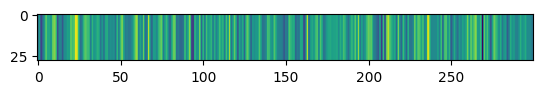

Train Epoch: 21 [800/1600 (50%)]	 KLD Loss: 0.000101 	 NLL Loss: 3109.895020


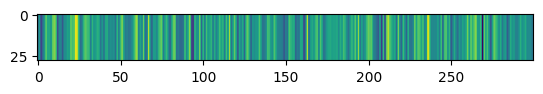

Train Epoch: 21 [960/1600 (59%)]	 KLD Loss: 0.000015 	 NLL Loss: 3108.863281


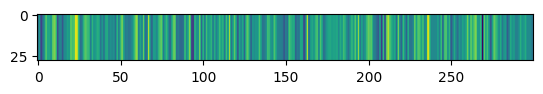

Train Epoch: 21 [1120/1600 (69%)]	 KLD Loss: 0.000155 	 NLL Loss: 3094.048340


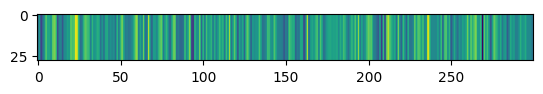

Train Epoch: 21 [1280/1600 (79%)]	 KLD Loss: 0.000027 	 NLL Loss: 3108.174805


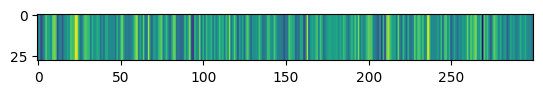

Train Epoch: 21 [1440/1600 (89%)]	 KLD Loss: 0.000236 	 NLL Loss: 3109.499756


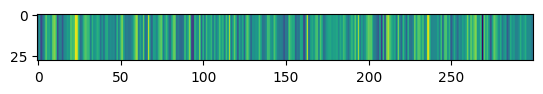

Train Epoch: 21 [1600/1600 (99%)]	 KLD Loss: 0.000016 	 NLL Loss: 779.895386


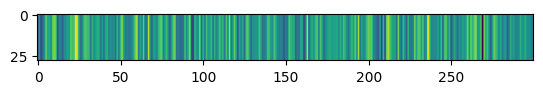

====> Epoch: 21 Average loss: 3109.4323
Train Epoch: 22 [0/1600 (0%)]	 KLD Loss: 0.000605 	 NLL Loss: 3101.699707


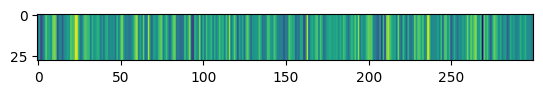

Train Epoch: 22 [160/1600 (10%)]	 KLD Loss: 0.001262 	 NLL Loss: 3108.162109


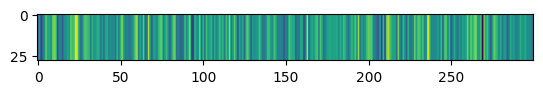

Train Epoch: 22 [320/1600 (20%)]	 KLD Loss: 0.000111 	 NLL Loss: 3108.322266


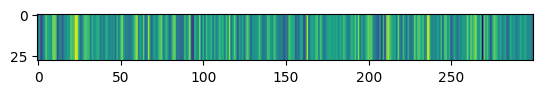

Train Epoch: 22 [480/1600 (30%)]	 KLD Loss: 0.000160 	 NLL Loss: 3109.561279


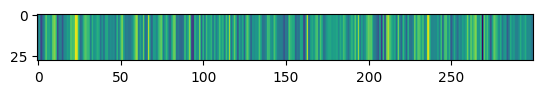

Train Epoch: 22 [640/1600 (40%)]	 KLD Loss: 0.000115 	 NLL Loss: 3104.950439


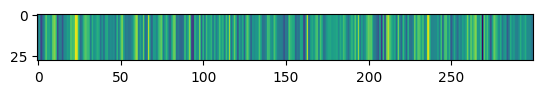

Train Epoch: 22 [800/1600 (50%)]	 KLD Loss: 0.000057 	 NLL Loss: 3109.137695


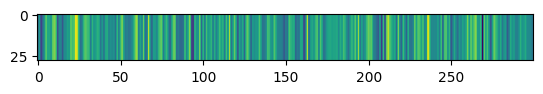

Train Epoch: 22 [960/1600 (59%)]	 KLD Loss: 0.000021 	 NLL Loss: 3109.919189


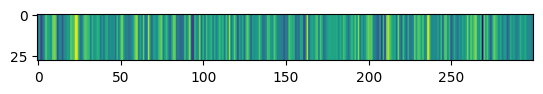

Train Epoch: 22 [1120/1600 (69%)]	 KLD Loss: 0.000022 	 NLL Loss: 3108.354248


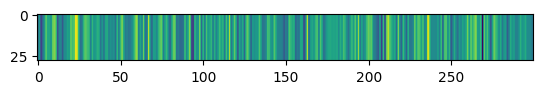

Train Epoch: 22 [1280/1600 (79%)]	 KLD Loss: 0.000025 	 NLL Loss: 3097.564453


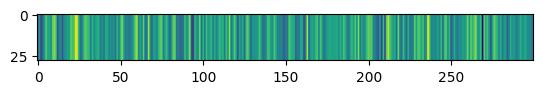

Train Epoch: 22 [1440/1600 (89%)]	 KLD Loss: 0.000020 	 NLL Loss: 3116.546387


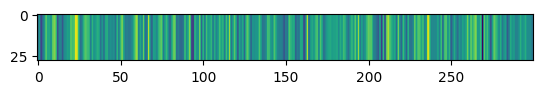

Train Epoch: 22 [1600/1600 (99%)]	 KLD Loss: 0.000004 	 NLL Loss: 777.954895


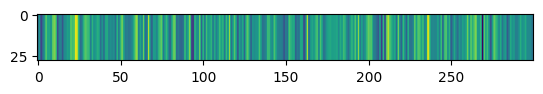

====> Epoch: 22 Average loss: 3109.7959
Train Epoch: 23 [0/1600 (0%)]	 KLD Loss: 0.000049 	 NLL Loss: 3093.579102


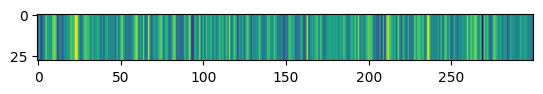

Train Epoch: 23 [160/1600 (10%)]	 KLD Loss: 0.000042 	 NLL Loss: 3132.790283


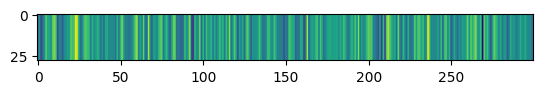

Train Epoch: 23 [320/1600 (20%)]	 KLD Loss: 0.000067 	 NLL Loss: 3107.067871


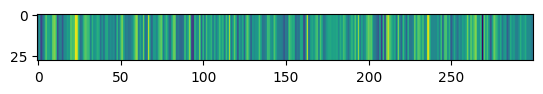

Train Epoch: 23 [480/1600 (30%)]	 KLD Loss: 0.000027 	 NLL Loss: 3118.503906


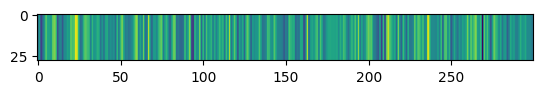

Train Epoch: 23 [640/1600 (40%)]	 KLD Loss: 0.000028 	 NLL Loss: 3104.899902


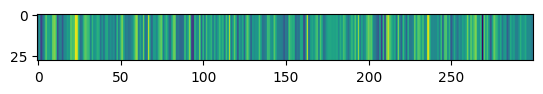

Train Epoch: 23 [800/1600 (50%)]	 KLD Loss: 0.000024 	 NLL Loss: 3102.194336


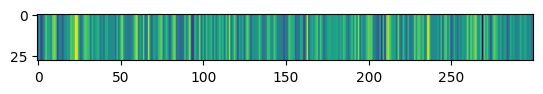

Train Epoch: 23 [960/1600 (59%)]	 KLD Loss: 0.000002 	 NLL Loss: 3109.828613


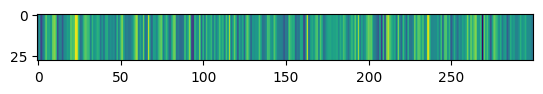

Train Epoch: 23 [1120/1600 (69%)]	 KLD Loss: 0.000030 	 NLL Loss: 3110.869385


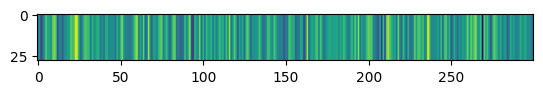

Train Epoch: 23 [1280/1600 (79%)]	 KLD Loss: 0.000036 	 NLL Loss: 3112.236084


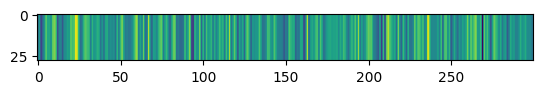

Train Epoch: 23 [1440/1600 (89%)]	 KLD Loss: 0.000014 	 NLL Loss: 3112.325439


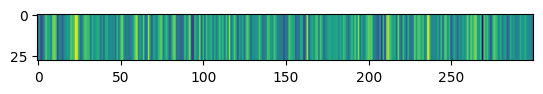

Train Epoch: 23 [1600/1600 (99%)]	 KLD Loss: 0.000002 	 NLL Loss: 770.992737


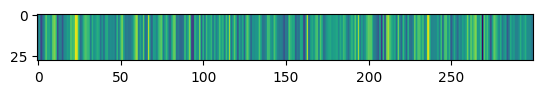

====> Epoch: 23 Average loss: 3108.5820
Train Epoch: 24 [0/1600 (0%)]	 KLD Loss: 0.000030 	 NLL Loss: 3116.324707


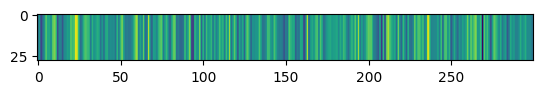

Train Epoch: 24 [160/1600 (10%)]	 KLD Loss: 0.000024 	 NLL Loss: 3111.350586


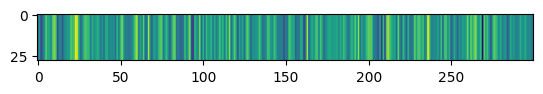

Train Epoch: 24 [320/1600 (20%)]	 KLD Loss: 0.000010 	 NLL Loss: 3098.971436


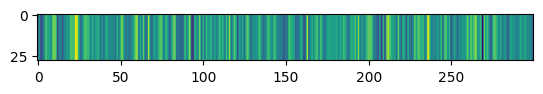

Train Epoch: 24 [480/1600 (30%)]	 KLD Loss: 0.000013 	 NLL Loss: 3107.924316


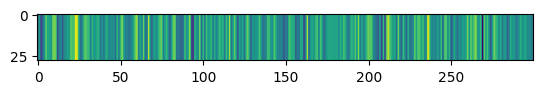

Train Epoch: 24 [640/1600 (40%)]	 KLD Loss: 0.000044 	 NLL Loss: 3116.031982


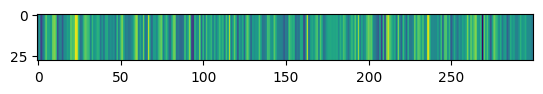

Train Epoch: 24 [800/1600 (50%)]	 KLD Loss: 0.000004 	 NLL Loss: 3103.387695


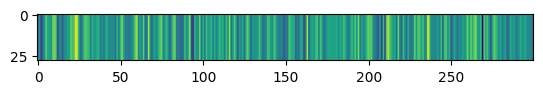

Train Epoch: 24 [960/1600 (59%)]	 KLD Loss: 0.000009 	 NLL Loss: 3110.385742


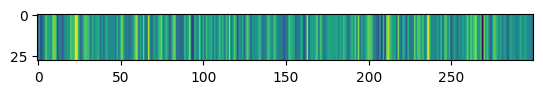

Train Epoch: 24 [1120/1600 (69%)]	 KLD Loss: 0.000099 	 NLL Loss: 3112.584717


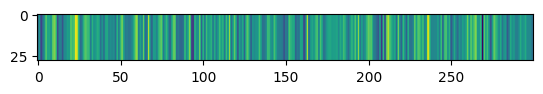

Train Epoch: 24 [1280/1600 (79%)]	 KLD Loss: 0.000059 	 NLL Loss: 3093.062988


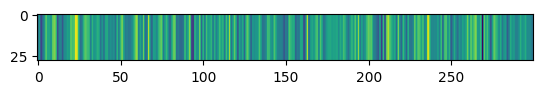

Train Epoch: 24 [1440/1600 (89%)]	 KLD Loss: 0.000036 	 NLL Loss: 3104.345215


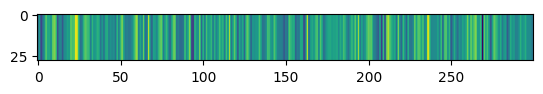

Train Epoch: 24 [1600/1600 (99%)]	 KLD Loss: 0.000002 	 NLL Loss: 778.143066


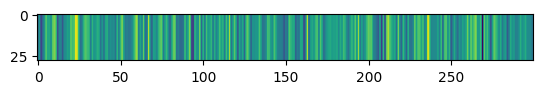

====> Epoch: 24 Average loss: 3110.4124
Train Epoch: 25 [0/1600 (0%)]	 KLD Loss: 0.000036 	 NLL Loss: 3107.995605


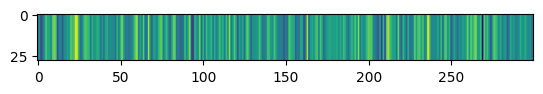

Train Epoch: 25 [160/1600 (10%)]	 KLD Loss: 0.000020 	 NLL Loss: 3104.420166


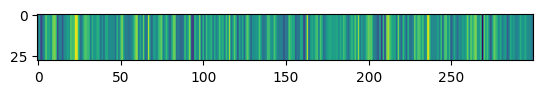

Train Epoch: 25 [320/1600 (20%)]	 KLD Loss: 0.000036 	 NLL Loss: 3128.685547


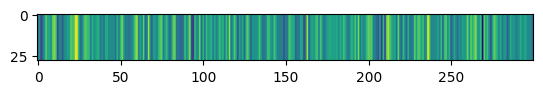

Train Epoch: 25 [480/1600 (30%)]	 KLD Loss: 0.000021 	 NLL Loss: 3099.761719


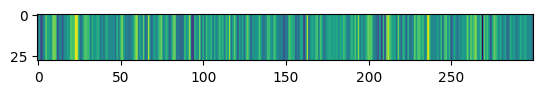

Train Epoch: 25 [640/1600 (40%)]	 KLD Loss: 0.000008 	 NLL Loss: 3110.416748


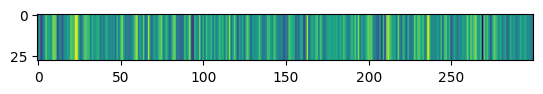

Train Epoch: 25 [800/1600 (50%)]	 KLD Loss: 0.000004 	 NLL Loss: 3091.064453


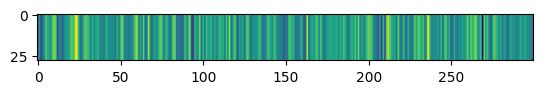

Train Epoch: 25 [960/1600 (59%)]	 KLD Loss: 0.000013 	 NLL Loss: 3093.762207


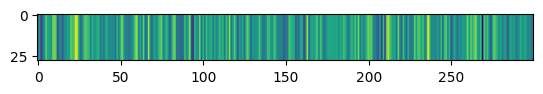

Train Epoch: 25 [1120/1600 (69%)]	 KLD Loss: 0.000007 	 NLL Loss: 3110.434570


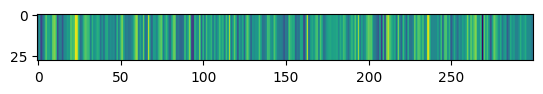

Train Epoch: 25 [1280/1600 (79%)]	 KLD Loss: 0.000013 	 NLL Loss: 3091.832031


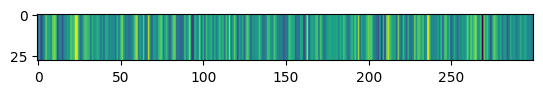

Train Epoch: 25 [1440/1600 (89%)]	 KLD Loss: 0.000008 	 NLL Loss: 3116.282471


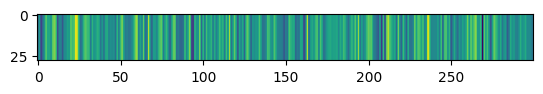

Train Epoch: 25 [1600/1600 (99%)]	 KLD Loss: 0.000002 	 NLL Loss: 776.777710


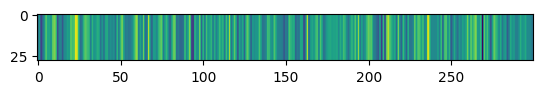

====> Epoch: 25 Average loss: 3108.4721
Train Epoch: 26 [0/1600 (0%)]	 KLD Loss: 0.000044 	 NLL Loss: 3115.820557


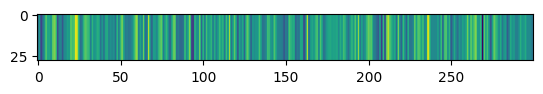

Train Epoch: 26 [160/1600 (10%)]	 KLD Loss: 0.000008 	 NLL Loss: 3109.222168


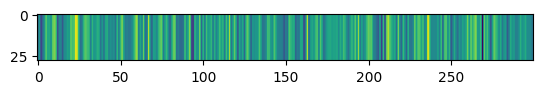

Train Epoch: 26 [320/1600 (20%)]	 KLD Loss: 0.000050 	 NLL Loss: 3103.437744


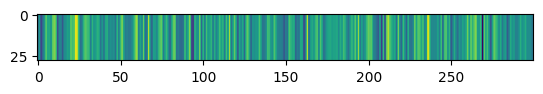

Train Epoch: 26 [480/1600 (30%)]	 KLD Loss: 0.000004 	 NLL Loss: 3102.065430


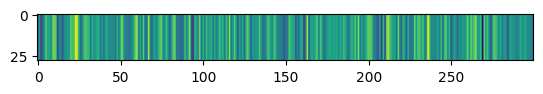

Train Epoch: 26 [640/1600 (40%)]	 KLD Loss: 0.000052 	 NLL Loss: 3097.396729


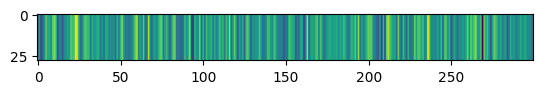

Train Epoch: 26 [800/1600 (50%)]	 KLD Loss: 0.000037 	 NLL Loss: 3123.222168


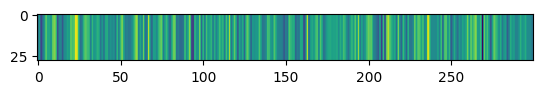

Train Epoch: 26 [960/1600 (59%)]	 KLD Loss: 0.000015 	 NLL Loss: 3136.251465


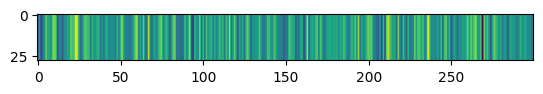

Train Epoch: 26 [1120/1600 (69%)]	 KLD Loss: 0.000036 	 NLL Loss: 3088.582031


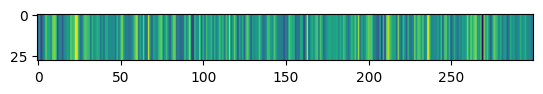

Train Epoch: 26 [1280/1600 (79%)]	 KLD Loss: 0.000002 	 NLL Loss: 3110.204346


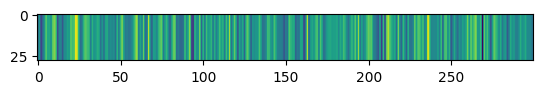

Train Epoch: 26 [1440/1600 (89%)]	 KLD Loss: 0.000002 	 NLL Loss: 3107.410645


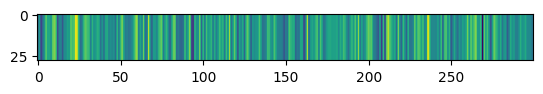

Train Epoch: 26 [1600/1600 (99%)]	 KLD Loss: 0.000001 	 NLL Loss: 776.562622


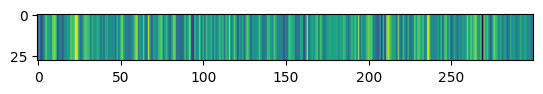

====> Epoch: 26 Average loss: 3108.4291
Train Epoch: 27 [0/1600 (0%)]	 KLD Loss: 0.000017 	 NLL Loss: 3115.253906


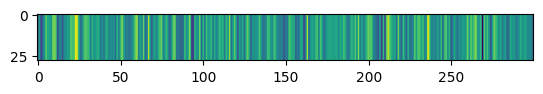

Train Epoch: 27 [160/1600 (10%)]	 KLD Loss: 0.000005 	 NLL Loss: 3102.780518


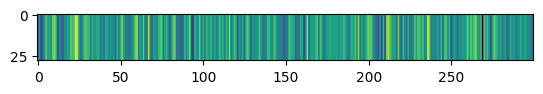

Train Epoch: 27 [320/1600 (20%)]	 KLD Loss: 0.000003 	 NLL Loss: 3102.589600


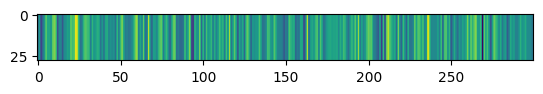

Train Epoch: 27 [480/1600 (30%)]	 KLD Loss: 0.000002 	 NLL Loss: 3122.137451


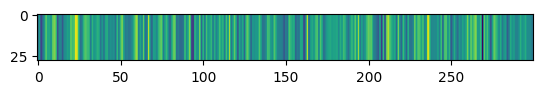

Train Epoch: 27 [640/1600 (40%)]	 KLD Loss: 0.000005 	 NLL Loss: 3117.616699


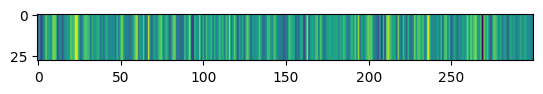

Train Epoch: 27 [800/1600 (50%)]	 KLD Loss: 0.000006 	 NLL Loss: 3108.482910


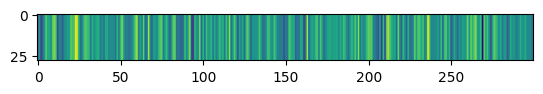

Train Epoch: 27 [960/1600 (59%)]	 KLD Loss: 0.000006 	 NLL Loss: 3110.017090


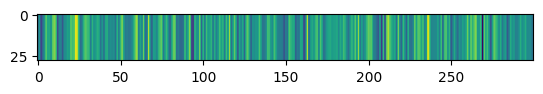

Train Epoch: 27 [1120/1600 (69%)]	 KLD Loss: 0.000013 	 NLL Loss: 3108.495850


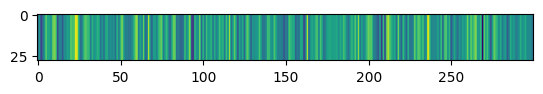

Train Epoch: 27 [1280/1600 (79%)]	 KLD Loss: 0.000002 	 NLL Loss: 3115.825928


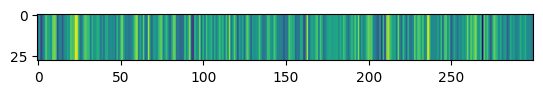

Train Epoch: 27 [1440/1600 (89%)]	 KLD Loss: 0.000008 	 NLL Loss: 3115.105713


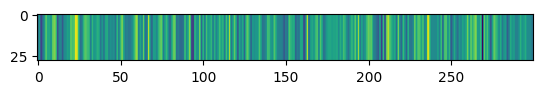

Train Epoch: 27 [1600/1600 (99%)]	 KLD Loss: 0.000003 	 NLL Loss: 776.833008


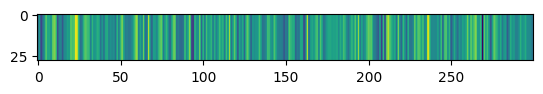

====> Epoch: 27 Average loss: 3108.0725
Train Epoch: 28 [0/1600 (0%)]	 KLD Loss: 0.000034 	 NLL Loss: 3126.222168


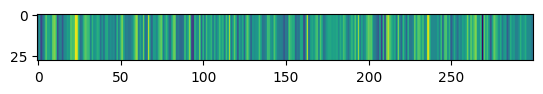

Train Epoch: 28 [160/1600 (10%)]	 KLD Loss: 0.000010 	 NLL Loss: 3111.800781


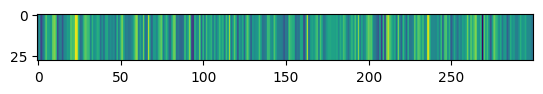

Train Epoch: 28 [320/1600 (20%)]	 KLD Loss: 0.000012 	 NLL Loss: 3100.645508


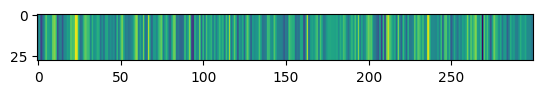

Train Epoch: 28 [480/1600 (30%)]	 KLD Loss: 0.000063 	 NLL Loss: 3090.832031


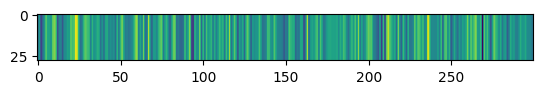

Train Epoch: 28 [640/1600 (40%)]	 KLD Loss: 0.000024 	 NLL Loss: 3085.067383


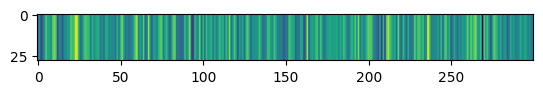

Train Epoch: 28 [800/1600 (50%)]	 KLD Loss: 0.000047 	 NLL Loss: 3110.006592


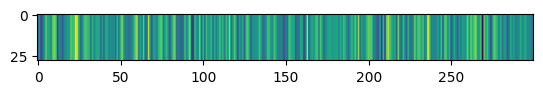

Train Epoch: 28 [960/1600 (59%)]	 KLD Loss: 0.000086 	 NLL Loss: 3105.299805


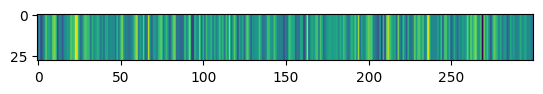

Train Epoch: 28 [1120/1600 (69%)]	 KLD Loss: 0.000014 	 NLL Loss: 3108.934814


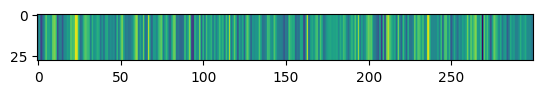

Train Epoch: 28 [1280/1600 (79%)]	 KLD Loss: 0.000001 	 NLL Loss: 3107.769775


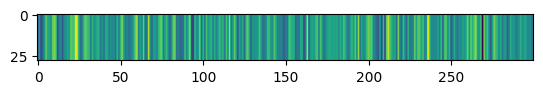

Train Epoch: 28 [1440/1600 (89%)]	 KLD Loss: 0.000004 	 NLL Loss: 3094.504883


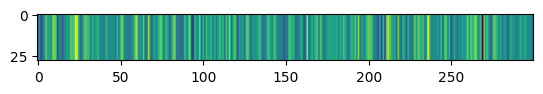

Train Epoch: 28 [1600/1600 (99%)]	 KLD Loss: 0.000006 	 NLL Loss: 778.617676


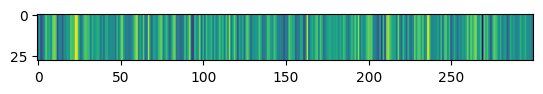

====> Epoch: 28 Average loss: 3109.1546
Train Epoch: 29 [0/1600 (0%)]	 KLD Loss: 0.000087 	 NLL Loss: 3113.109375


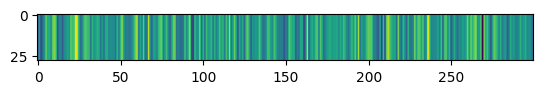

Train Epoch: 29 [160/1600 (10%)]	 KLD Loss: 0.000066 	 NLL Loss: 3120.660645


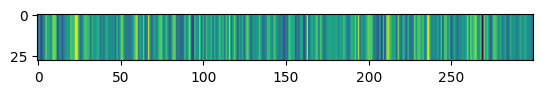

Train Epoch: 29 [320/1600 (20%)]	 KLD Loss: 0.000021 	 NLL Loss: 3116.031982


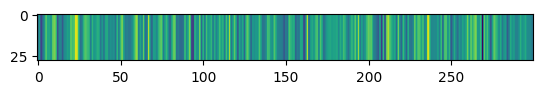

Train Epoch: 29 [480/1600 (30%)]	 KLD Loss: 0.000006 	 NLL Loss: 3077.053955


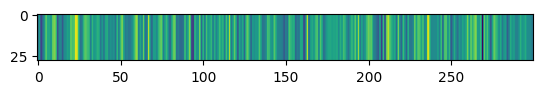

Train Epoch: 29 [640/1600 (40%)]	 KLD Loss: 0.000022 	 NLL Loss: 3127.528320


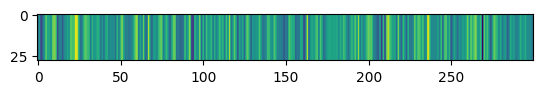

Train Epoch: 29 [800/1600 (50%)]	 KLD Loss: 0.000006 	 NLL Loss: 3090.806396


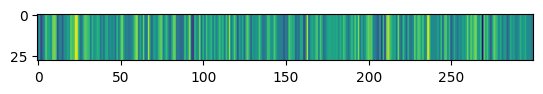

Train Epoch: 29 [960/1600 (59%)]	 KLD Loss: 0.000004 	 NLL Loss: 3092.733154


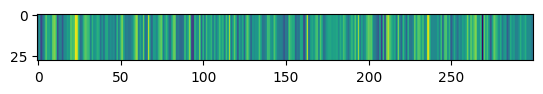

Train Epoch: 29 [1120/1600 (69%)]	 KLD Loss: 0.000004 	 NLL Loss: 3120.942627


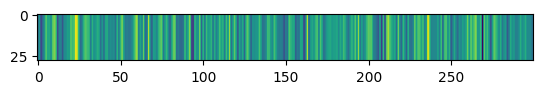

Train Epoch: 29 [1280/1600 (79%)]	 KLD Loss: 0.000012 	 NLL Loss: 3117.111572


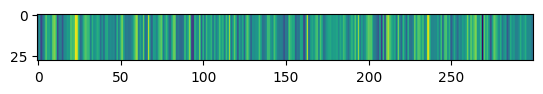

Train Epoch: 29 [1440/1600 (89%)]	 KLD Loss: 0.000004 	 NLL Loss: 3109.053955


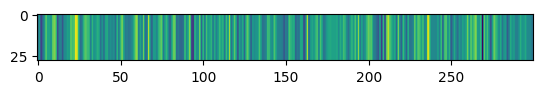

Train Epoch: 29 [1600/1600 (99%)]	 KLD Loss: 0.000001 	 NLL Loss: 777.361267


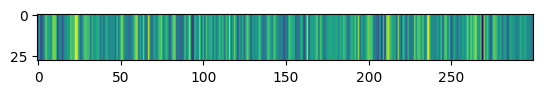

====> Epoch: 29 Average loss: 3108.8475
Train Epoch: 30 [0/1600 (0%)]	 KLD Loss: 0.000007 	 NLL Loss: 3101.201172


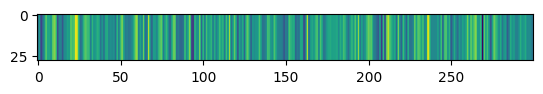

Train Epoch: 30 [160/1600 (10%)]	 KLD Loss: 0.000005 	 NLL Loss: 3100.872070


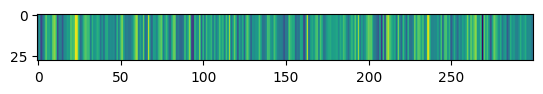

Train Epoch: 30 [320/1600 (20%)]	 KLD Loss: 0.000003 	 NLL Loss: 3111.887695


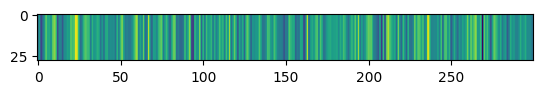

Train Epoch: 30 [480/1600 (30%)]	 KLD Loss: 0.000020 	 NLL Loss: 3097.913086


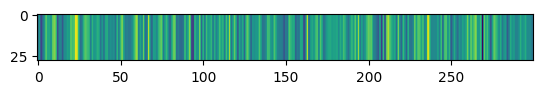

Train Epoch: 30 [640/1600 (40%)]	 KLD Loss: 0.000024 	 NLL Loss: 3109.521484


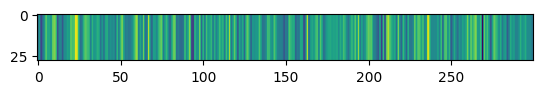

Train Epoch: 30 [800/1600 (50%)]	 KLD Loss: 0.000006 	 NLL Loss: 3111.284668


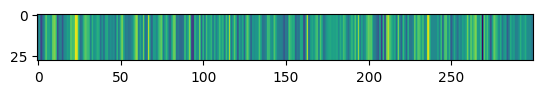

Train Epoch: 30 [960/1600 (59%)]	 KLD Loss: 0.000007 	 NLL Loss: 3111.794189


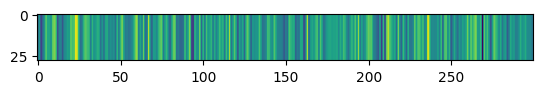

Train Epoch: 30 [1120/1600 (69%)]	 KLD Loss: 0.000003 	 NLL Loss: 3093.668701


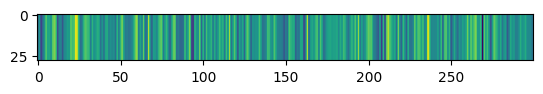

Train Epoch: 30 [1280/1600 (79%)]	 KLD Loss: 0.000006 	 NLL Loss: 3106.493652


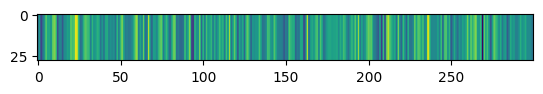

Train Epoch: 30 [1440/1600 (89%)]	 KLD Loss: 0.000001 	 NLL Loss: 3099.024658


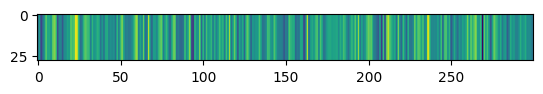

Train Epoch: 30 [1600/1600 (99%)]	 KLD Loss: 0.000001 	 NLL Loss: 778.764526


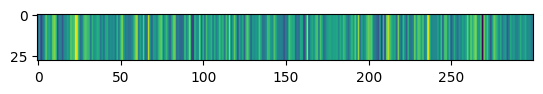

====> Epoch: 30 Average loss: 3109.1245
[tensor([[[ 1.0000e+00,  1.1129e-03,  7.7174e-01,  6.8664e-02,  9.7532e-03,
           3.9214e-02,  9.9458e-01,  9.9999e-01, -1.0000e+00,  6.8069e-01,
           7.2500e-02, -3.5603e-03,  9.9817e-01,  6.1348e-02,  3.6948e-02,
          -7.0924e-03, -9.9571e-01, -4.9566e-02, -1.1062e-01, -9.8998e-01,
          -9.8265e-01, -8.1428e-02, -9.7441e-01, -5.3678e-03, -1.0000e+00,
           9.9996e-01,  9.9984e-01,  9.7557e-01, -9.1473e-01, -4.9060e-02,
          -9.9980e-01,  1.8600e-01, -4.7426e-03, -9.9729e-01, -8.4825e-01,
           9.1627e-02, -3.6468e-01, -9.9920e-01,  9.6867e-01,  1.2063e-01,
          -1.8091e-02,  3.1516e-01,  1.3028e-01,  9.4521e-01,  2.6361e-03,
           1.1411e-02,  9.7058e-01, -9.9998e-01,  9.2689e-01, -1.0874e-01],
         [ 1.0000e+00,  9.5278e-04,  7.5152e-01,  6.5505e-02,  9.9454e-03,
           3.7163e-02,  9.9448e-01,  9.9999e-01, -1.0000e+00,  6.2108e-01,
           7.4292e-02, -2.8190e-03,  9.9796e-01,  5.8633e-

In [ ]:
x_dim = 300
h_dim = 50
z_dim = 10
n_layers = 1
n_epochs = 30
clip = 10
learning_rate = 0.016
batch_size = 16
seed = 12
print_every = 10 # batches
hiddens =[]

losses = []
def train(epoch,train_loader):
    train_loss = 0
    hidden=[]
    for batch_idx,data in enumerate(train_loader):
        # transforming data
        data = data.to(device)
        data = data.squeeze().transpose(0, 1)  # (seq, batch, elem)
        data = (data - data.min()) / (data.max() - data.min())



        # forward + backward + optimize
        optimizer.zero_grad()
        kld_loss, nll_loss,h, _, _ = model(data)
        hidden = h
        loss = kld_loss + nll_loss
        loss.backward()
        optimizer.step()

        # grad norm clipping, only in pytorch version >= 1.10
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # printing
        if batch_idx % print_every == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, batch_size *
                (len(train_loader.dataset)//batch_size),
                100. * batch_idx / len(train_loader),
                kld_loss / batch_size,
                nll_loss / batch_size))

            sample = model.sample(torch.tensor(28, device=device))
            plt.imshow(sample.to(torch.device('cpu')).numpy())
            plt.pause(1e-6)

        train_loss += loss.item()
    losses.append(train_loss)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    return hidden


def test(epoch , test_loader):


    mean_kld_loss, mean_nll_loss = 0, 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):

            data = data.to(device)
            data = data.squeeze().transpose(0, 1)
            data = (data - data.min()) / (data.max() - data.min())


            kld_loss, nll_loss,h, _, _ = model(data)
            mean_kld_loss += kld_loss.item()
            mean_nll_loss += nll_loss.item()

    mean_kld_loss /= len(test_loader.dataset)
    mean_nll_loss /= len(test_loader.dataset)

    print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
        mean_kld_loss, mean_nll_loss))



for iter in range(0,2):
  hid = []
  model = VRNN(x_dim, h_dim, z_dim, n_layers)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(1, n_epochs + 1):

      # training + testing
      hid = train(epoch,train_loaders[iter])
      #test(epoch,test_loaders[iter])
  hiddens.append(hid)
    # saving model
    # if epoch % save_every == 1:
    #     fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
    #     torch.save(model.state_dict(), fn)
    #     print('Saved model to '+fn)

print(hiddens)

In [ ]:
save_hiddens =[]

for i in range(len(hiddens)):
  h = list(hiddens[i][:,-1,:][0].detach().cpu().numpy())
  save_hiddens = save_hiddens + h

save_hiddens = np.array(save_hiddens)
np.save('hiddens' , save_hiddens)

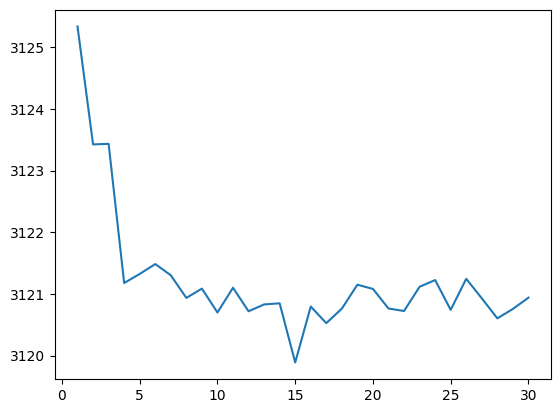

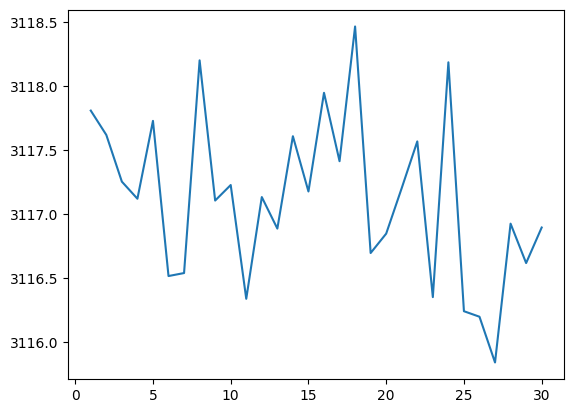

4987035.642578125

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
a = [1136,1600]
y_axis = np.arange(1,n_epochs+1,1)
for i in range(len(losses)//n_epochs):
  x_axis = np.array(losses[i*n_epochs : (i+1)*n_epochs])/a[i]
  plt.plot(y_axis , x_axis)
  plt.title('loss vs epochs graph')
  plt.xlabel('epochs')
  plt.ylabel('Reconstruction loss')
  plt.xticks(range(1, 21))
  plt.show()
losses[2*n_epochs-1]


In [ ]:
print(losses[0]/(1136))

3123.9213377186948
